In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
cd gdrive/My\ Drive/Help-Hinder_GNN_Project

/content/gdrive/My Drive/Help-Hinder_GNN_Project


# **PHASE Main Set**

## Load Model Predictions, Human Ratings, PHASE Labels

SIMPLE Predictions

In [5]:
dataset = "train" #this is what our phase main plot is using

if dataset == "train":
  f = open('./SIMPLE-new-main/SIMPLE_predicted_labels_train_partial', 'r')
elif dataset == "train_new":
  f = open('./SIMPLE-new-main/SIMPLE_predicted_labels_train_unrenderedunflipped', 'r')

entries = f.read().splitlines()
print("last episode no.", entries[-10]) #starts with episode 0
n = 399
print(entries[-1])


predictions = []

for e in range(1,n*6,6):
  v = dict()
  if dataset == "train":
    v['name'] = entries[e].split("/")[2][:24]
  elif dataset == "train_new":
    v['name'] = entries[e].split("/")[2][:23] #this and next line when using inference on train_new
    v['name'] = v['name'][:14] + '0' + v['name'][14:]

  v['inference'] = entries[e+2].split(" ")[2]
  v['gt'] = entries[e+4].split(" ")[2]
  predictions.append(v)

import pandas as pd
SIMPLE = pd.DataFrame(predictions)

#import numpy as np
#SIMPLE['correct'] = SIMPLE.apply(lambda x: 1 if x['inference']==x['gt'] else 0, axis = 1)
#print(np.mean(SIMPLE['correct']))
display(SIMPLE)

SIMPLE_dict = SIMPLE.set_index('name').T.to_dict('dict')

last episode no. episode_id: 398
relation accuracy: 0.7192982456140351


,name,inference,gt
0,D081820_13363300_0_F8_E0,friendly,friendly
1,D081820_16545200_0_F8_E2,adversarial,adversarial
2,D081920_01561200_0_F8_E6,adversarial,adversarial
3,D081920_03595900_0_F8_E7,adversarial,adversarial
4,D081920_08023200_0_F8_E6,friendly,friendly
...,...,...,...
394,D121320_07145900_0_F8_E2,adversarial,friendly
395,D121320_13405400_0_F8_E1,friendly,friendly
396,D121420_00140200_0_F8_E1,friendly,friendly
397,D121420_08260200_0_F8_E1,adversarial,friendly


Human Ratings: Labels and Agreement

In [6]:
import numpy as np
from collections import Counter
import pickle

with open('./SocialGNN_Final/Human_Experiment_Files/human_rating_labels', 'rb') as file:
    human_ratings_labels_dict = pickle.load(file)

HR_dict = {}
full_names = {}
for v,label in human_ratings_labels_dict.items():
  HR_dict[v[:24]] = label
  full_names[v[:24]] = v

with open('./SocialGNN_Final/Human_Experiment_Files/human_rating_labels_agreement', 'rb') as file:
  HR_agreement_dict = pickle.load(file)

temp = {}
for k,v in HR_agreement_dict.items():
  temp[k[:24]] = v['relationship']

HR_agreement_dict = temp

## Combining our HR, PHASE HR, SIMPLE GT, PHASE GT, our pred, SIMPLE pred

In [7]:
def combine(pred_SocialGNN, pred_CueBasedLSTM, pred_CueBasedLSTM_R, SIMPLE_dict, HR_dict):
  names = []
  HR = []
  GT_SIMPLE = []
  Pred_SIMPLE = []
  Pred_SocialGNN = []
  Pred_CueBasedLSTM = []
  Pred_CueBasedLSTM_R = []
  for name, pred in pred_SocialGNN.items():
      try:
        GT_SIMPLE.append(SIMPLE_dict[name]['gt'])
        Pred_SIMPLE.append(SIMPLE_dict[name]['inference'])

        Pred_SocialGNN.append(pred_SocialGNN[name])
        Pred_CueBasedLSTM.append(pred_CueBasedLSTM[name])
        Pred_CueBasedLSTM_R.append(pred_CueBasedLSTM_R[name])

        HR.append(HR_dict[name]['relationship'])
        names.append(full_names[name])
      except:
        print("entry not found")

        GT_SIMPLE.append("NaN")
        Pred_SIMPLE.append("NaN")

        Pred_SocialGNN.append(pred_SocialGNN[name])
        Pred_CueBasedLSTM.append(pred_CueBasedLSTM[name])
        Pred_CueBasedLSTM_R.append(pred_CueBasedLSTM_R[name])

        HR.append(HR_dict[name]['relationship'])
        names.append(full_names[name])

  print("HR", Counter(HR))
  print("GT_SIMPLE", Counter(GT_SIMPLE))

  print("Pred SocialGNN", Counter(Pred_SocialGNN))
  print("Pred CueBasedLSTM", Counter(Pred_CueBasedLSTM))
  print("Pred CueBasedLSTM_R", Counter(Pred_CueBasedLSTM_R))
  print("Pred SIMPLE", Counter(Pred_SIMPLE))

  return names, Pred_SocialGNN, Pred_CueBasedLSTM, Pred_CueBasedLSTM_R, Pred_SIMPLE, GT_SIMPLE, HR

def get_accuracy(a,b):
  mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2, 'NaN' : float("NaN")}
  #accuracy = np.mean(np.equal([mapping[x] for x in a], [mapping[x] for x in b]))
  n = min(sum(~np.isnan([mapping[x] for x in a])), sum(~np.isnan([mapping[x] for x in b])))
  accuracy = np.sum(np.equal([mapping[x] for x in a], [mapping[x] for x in b]))/n
  return accuracy

def load_combine_and_accuracy_onebootstrap(pred_string, bootstrap_no, SIMPLE_dict, HR_dict, save_predictions_mode =False):
  with open(pred_string + str(bootstrap_no) + '_SocialGNN_E', "rb") as f:
    true = pickle.load(f)
    pred = pickle.load(f)

  pred_SocialGNN = {}
  for v,label in pred.items():
    pred_SocialGNN[v[:24]] = label


  with open(pred_string + str(bootstrap_no) + '_CueBasedLSTM', "rb") as f:
    true = pickle.load(f)
    pred = pickle.load(f)

  pred_CueBasedLSTM = {}
  for v,label in pred.items():
    pred_CueBasedLSTM[v[:24]] = label

  with open(pred_string + str(bootstrap_no) + '_CueBasedLSTM-Relation', "rb") as f:
    true = pickle.load(f)
    pred = pickle.load(f)

  pred_CueBasedLSTM_R = {}
  for v,label in pred.items():
    pred_CueBasedLSTM_R[v[:24]] = label

  names, Pred_SocialGNN, Pred_CueBasedLSTM, Pred_CueBasedLSTM_R, Pred_SIMPLE, GT_SIMPLE, HR = combine(pred_SocialGNN, pred_CueBasedLSTM, pred_CueBasedLSTM_R, SIMPLE_dict, HR_dict)

  print(get_accuracy(Pred_SocialGNN, HR))
  print(get_accuracy(Pred_CueBasedLSTM, HR))
  print(get_accuracy(Pred_CueBasedLSTM_R, HR))
  print(get_accuracy(Pred_SIMPLE, HR))
  print()
  print(get_accuracy(Pred_SocialGNN, GT_SIMPLE))
  print(get_accuracy(Pred_SIMPLE, GT_SIMPLE))

  if save_predictions_mode == True:
    return names, Pred_SocialGNN, Pred_CueBasedLSTM, Pred_CueBasedLSTM_R, Pred_SIMPLE, GT_SIMPLE, HR

  return get_accuracy(Pred_SocialGNN, HR), get_accuracy(Pred_CueBasedLSTM, HR), get_accuracy(Pred_CueBasedLSTM_R, HR), get_accuracy(Pred_SIMPLE, HR)



## Accuracies Plot

In [8]:
from sklearn import metrics
import sklearn
accuracies = {'SocialGNN':[], 'CueBasedLSTM':[], 'CueBasedLSTM_R':[], 'SIMPLE':[]}
confusion_matrices = {'SocialGNN':[], 'CueBasedLSTM':[], 'CueBasedLSTM_R':[], 'SIMPLE':[]}
for bootstrap_no in range(10):
  print("\n\n", bootstrap_no)
  #pred_string = './Predictions/PHASE_mysplit_humanratings_May1_'
  pred_string = './Predictions/PHASE_mysplit_humanratings_contextTrue_20230503__20230508_'
  acc_SocialGNN, acc_CueBasedLSTM, acc_CueBasedLSTM_R, acc_SIMPLE = load_combine_and_accuracy_onebootstrap(pred_string, bootstrap_no, SIMPLE_dict, HR_dict)
  accuracies['SocialGNN'].append(acc_SocialGNN)
  accuracies['CueBasedLSTM'].append(acc_CueBasedLSTM)
  accuracies['CueBasedLSTM_R'].append(acc_CueBasedLSTM_R)
  accuracies['SIMPLE'].append(acc_SIMPLE)

  names, Pred_SocialGNN, Pred_CueBasedLSTM, Pred_CueBasedLSTM_R, Pred_SIMPLE, GT_SIMPLE, HR = load_combine_and_accuracy_onebootstrap(pred_string, bootstrap_no, SIMPLE_dict, HR_dict, save_predictions_mode =True)

  if bootstrap_no==0:
    confusion_matrices['SocialGNN'] = sklearn.metrics.confusion_matrix(HR, Pred_SocialGNN, labels=['friendly', 'neutral', 'adversarial'])
    confusion_matrices['CueBasedLSTM'] = sklearn.metrics.confusion_matrix(HR, Pred_CueBasedLSTM, labels=['friendly', 'neutral', 'adversarial'])
    confusion_matrices['CueBasedLSTM_R'] = sklearn.metrics.confusion_matrix(HR, Pred_CueBasedLSTM_R, labels=['friendly', 'neutral', 'adversarial'])
    confusion_matrices['SIMPLE'] = sklearn.metrics.confusion_matrix(HR, Pred_SIMPLE, labels=['friendly', 'neutral', 'adversarial'])
  else:
    confusion_matrices['SocialGNN'] = np.dstack((confusion_matrices['SocialGNN'], sklearn.metrics.confusion_matrix(HR, Pred_SocialGNN, labels=['friendly', 'neutral', 'adversarial'])))
    confusion_matrices['CueBasedLSTM'] = np.dstack((confusion_matrices['CueBasedLSTM'], sklearn.metrics.confusion_matrix(HR, Pred_CueBasedLSTM, labels=['friendly', 'neutral', 'adversarial'])))
    confusion_matrices['CueBasedLSTM_R'] = np.dstack((confusion_matrices['CueBasedLSTM_R'], sklearn.metrics.confusion_matrix(HR, Pred_CueBasedLSTM_R, labels=['friendly', 'neutral', 'adversarial'])))
    confusion_matrices['SIMPLE'] = np.dstack((confusion_matrices['SIMPLE'], sklearn.metrics.confusion_matrix(HR, Pred_SIMPLE, labels=['friendly', 'neutral', 'adversarial'])))



 0
entry not found
HR Counter({'friendly': 40, 'adversarial': 36, 'neutral': 24})
GT_SIMPLE Counter({'friendly': 43, 'adversarial': 38, 'neutral': 18, 'NaN': 1})
Pred SocialGNN Counter({'friendly': 43, 'adversarial': 32, 'neutral': 25})
Pred CueBasedLSTM Counter({'friendly': 39, 'adversarial': 33, 'neutral': 28})
Pred CueBasedLSTM_R Counter({'adversarial': 41, 'friendly': 36, 'neutral': 23})
Pred SIMPLE Counter({'adversarial': 49, 'friendly': 35, 'neutral': 15, 'NaN': 1})
0.83
0.56
0.59
0.696969696969697

0.7878787878787878
0.7474747474747475
entry not found
HR Counter({'friendly': 40, 'adversarial': 36, 'neutral': 24})
GT_SIMPLE Counter({'friendly': 43, 'adversarial': 38, 'neutral': 18, 'NaN': 1})
Pred SocialGNN Counter({'friendly': 43, 'adversarial': 32, 'neutral': 25})
Pred CueBasedLSTM Counter({'friendly': 39, 'adversarial': 33, 'neutral': 28})
Pred CueBasedLSTM_R Counter({'adversarial': 41, 'friendly': 36, 'neutral': 23})
Pred SIMPLE Counter({'adversarial': 49, 'friendly': 35, '

In [9]:
!pip install statannotations

<ipython-input-15-c2fdc0996e58>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")


('SocialGNN', 'VisualRNN') 17.7 0.001953125
('SocialGNN', 'VisualRNN-Rel') 18.000000000000004 0.001953125
('SocialGNN', 'Inverse Planning (SIMPLE)') 11.56262626262626 0.001953125
('Inverse Planning (SIMPLE)', 'VisualRNN') 6.13737373737374 0.017578125
('Inverse Planning (SIMPLE)', 'VisualRNN-Rel') 6.43737373737374 0.009765625
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SocialGNN vs. VisualRNN: Custom statistical test with Holm-Bonferroni correction, P_val:1.953e-03
VisualRNN-Rel vs. Inverse Planning (SIMPLE): Custom statistical test with Holm-Bonferroni correction, P_val:9.766e-03
SocialGNN vs. VisualRNN-Rel: Custom statistical test with Holm-Bonferroni correction, P_val:1.953e-03
VisualRNN vs. Inverse Planning (SIMPLE): Custom statistical test with Holm-Bonferroni correction, P_val:1.758e-02
SocialGNN vs. Inverse Planning (SIMPLE): Custom statistical 

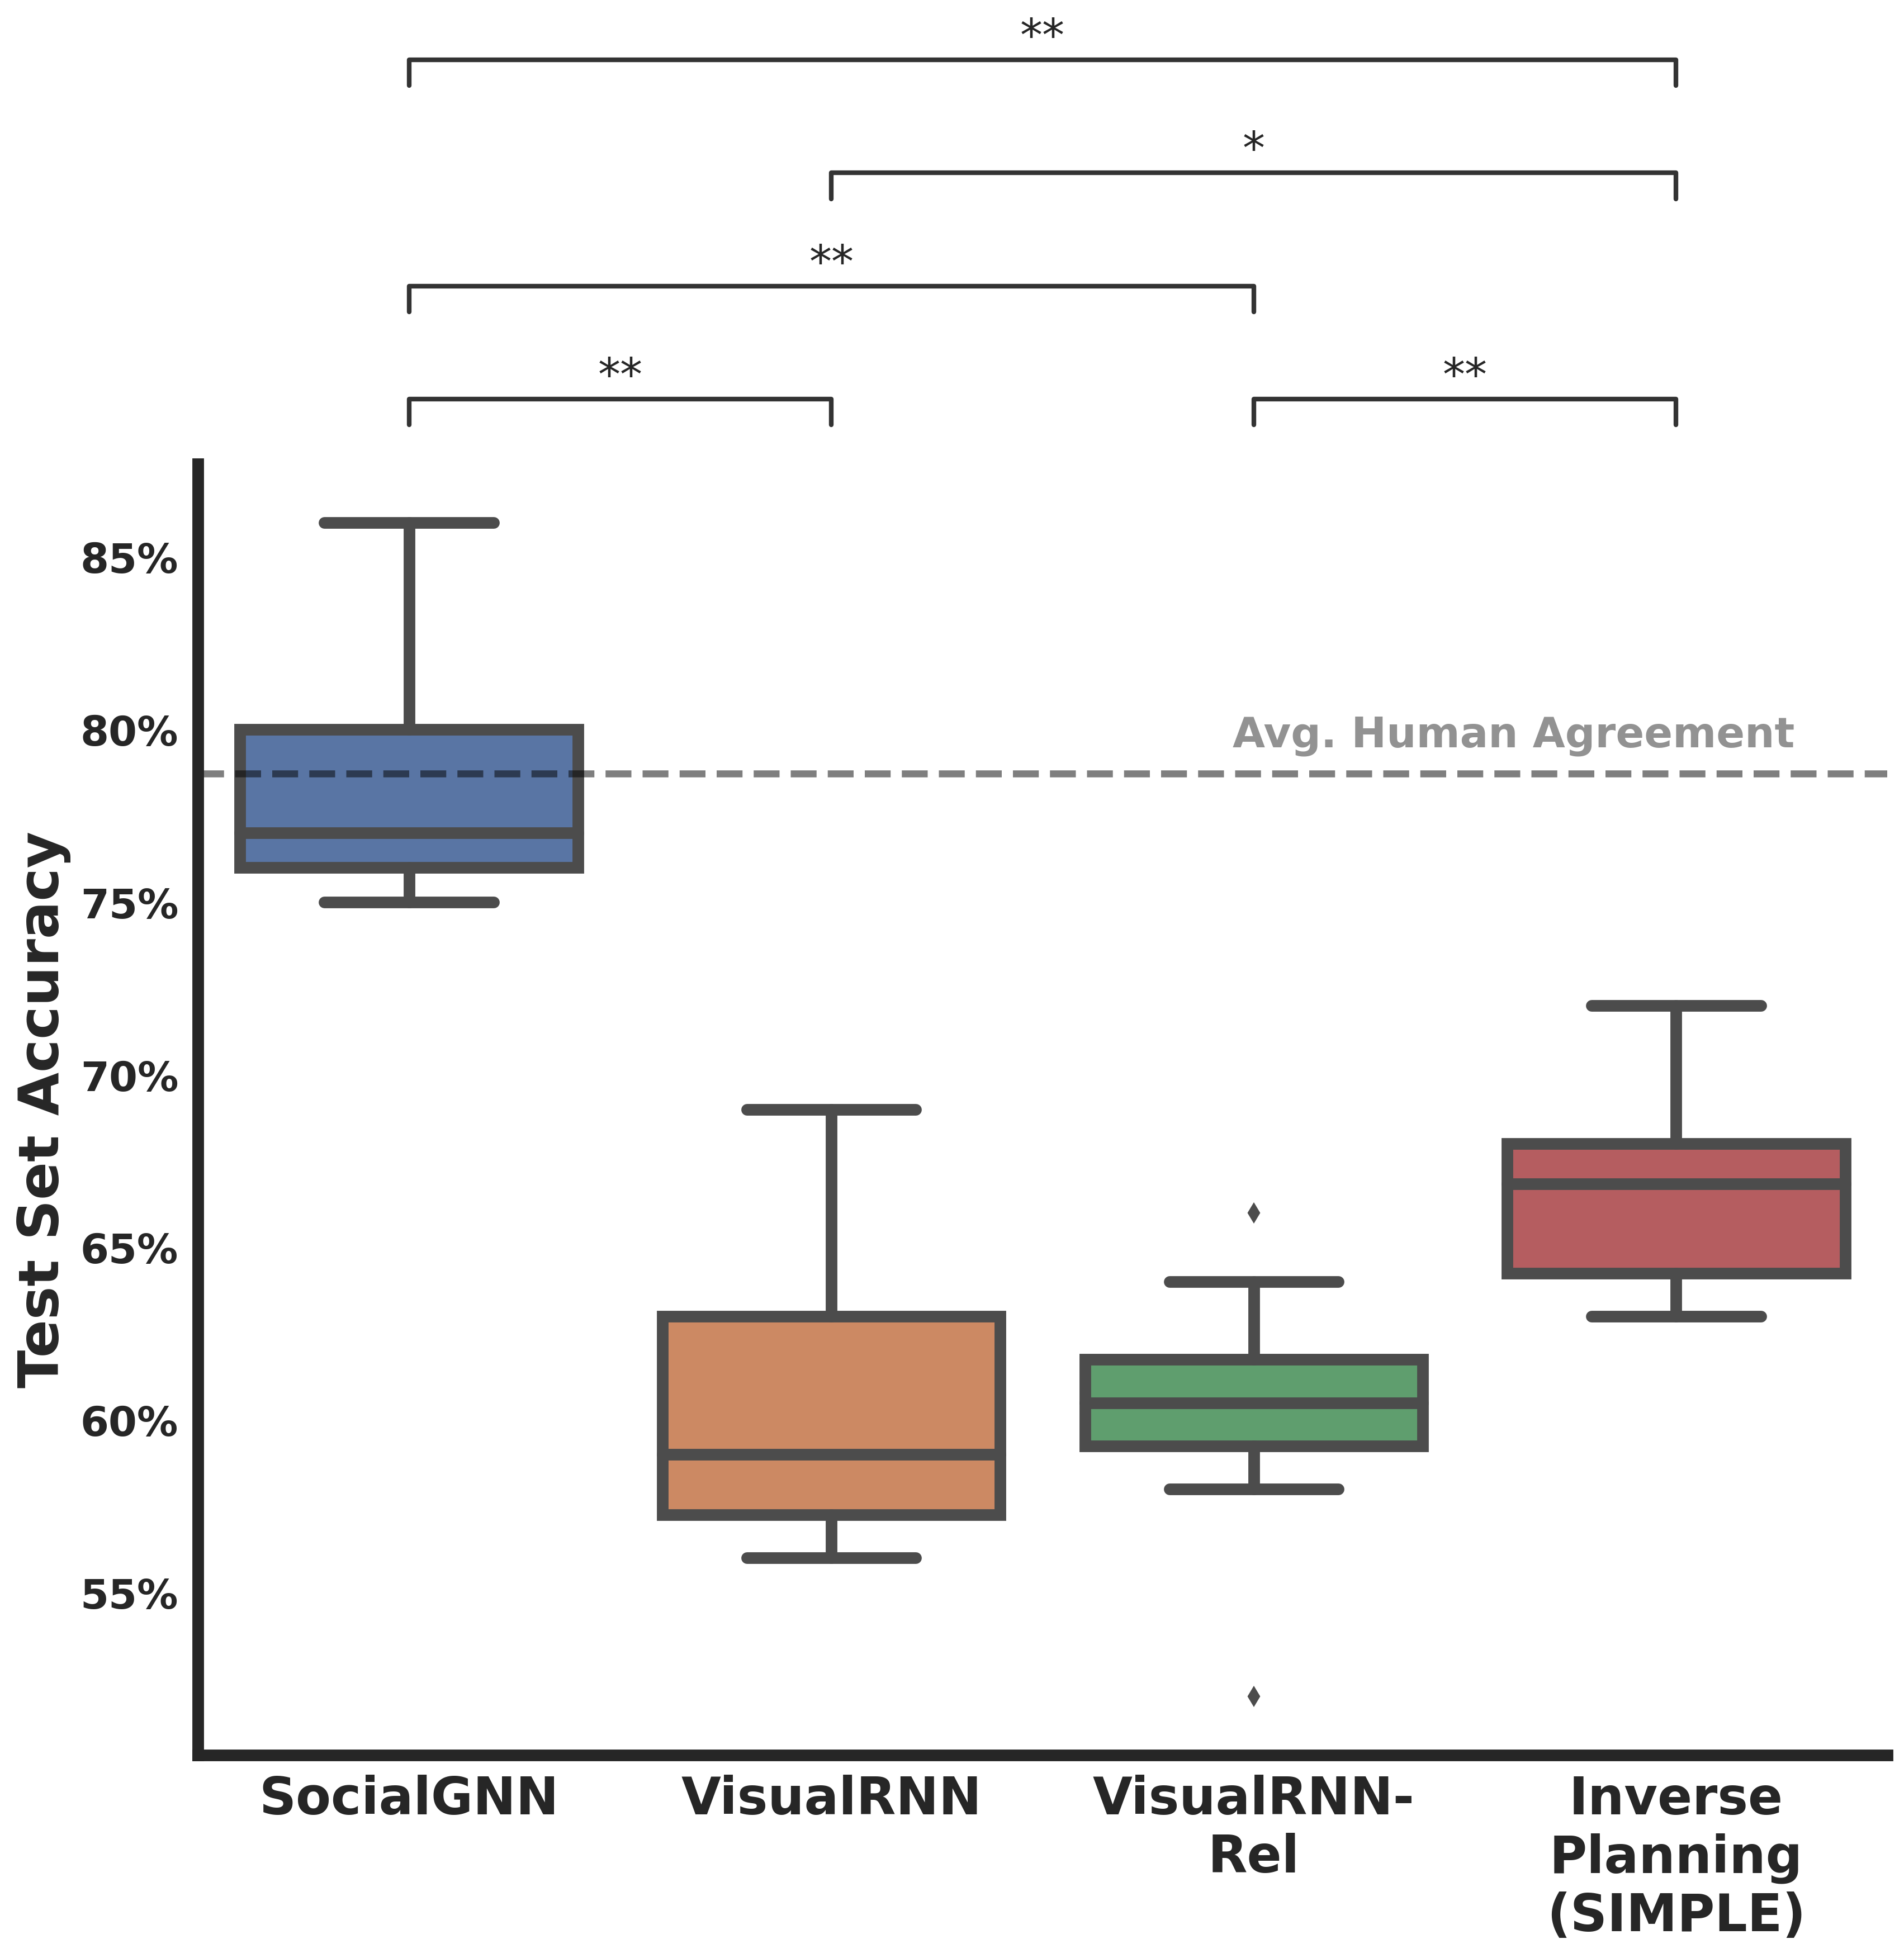

In [15]:
from statannotations.stats.StatTest import StatTest
from statannotations.Annotator import Annotator
from scipy.stats import permutation_test
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

SocialGNN_E = {'testset': accuracies['SocialGNN']}
CueBasedLSTM_6 = {'testset': accuracies['CueBasedLSTM']}
CueBasedLSTM_Relation_6 = {'testset': accuracies['CueBasedLSTM_R']}
SIMPLE = {'testset': accuracies['SIMPLE']}

def paired_mean_difference(data2, data1):
    return np.mean(np.array(data2) - np.array(data1))

df = pd.concat([pd.DataFrame(SocialGNN_E), pd.DataFrame(CueBasedLSTM_6), pd.DataFrame(CueBasedLSTM_Relation_6), pd.DataFrame(SIMPLE)], keys=['SocialGNN', 'VisualRNN', 'VisualRNN-Rel', 'Inverse Planning (SIMPLE)']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")
plt.rcParams["figure.figsize"] = (13,10)

f = sns.boxplot(x="model",y="testset_accuracy", data=df, linewidth=5)
#f.axhline(0.33, color = "black", ls = "--", alpha = 0.5)
f.axhline(0.7872, color = "black", ls = "--", alpha = 0.5, linewidth = 3)
f.text(1.95, 0.795, "Avg. Human Agreement", fontsize=18, weight="bold", alpha = 0.5) #, bbox=dict(facecolor='red', alpha=0.5))

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 12) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=22)
f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=24)

# Significance testing
order = ['SocialGNN', 'VisualRNN', 'VisualRNN-Rel', 'Inverse Planning (SIMPLE)']
pairs=[("SocialGNN", "VisualRNN"), ("SocialGNN", "VisualRNN-Rel"), ('SocialGNN', 'Inverse Planning (SIMPLE)'),('Inverse Planning (SIMPLE)', 'VisualRNN'), ('Inverse Planning (SIMPLE)', 'VisualRNN-Rel') ]
annotator = Annotator(f, pairs, data=df, x="model", y="testset_accuracy", order=order)
pvalues = []
for pair in pairs:
    data1 = df.groupby('model')['testset_accuracy'].get_group(pair[0])
    data2 = df.groupby('model')['testset_accuracy'].get_group(pair[1])
    res = permutation_test((data1, data2), statistic=paired_mean_difference, permutation_type='samples', n_resamples=10000)
    print(pair, res.statistic*100, res.pvalue)
    pvalues.append(res.pvalue)
(annotator
 .configure(comparisons_correction="HB", test=None, test_short_name='permuation_test', text_format='star', loc='outside', line_width = 2, line_offset=0.01, text_offset=0.01)
 .set_pvalues(pvalues=pvalues)
 .annotate())

sns.despine()
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

from google.colab import files
plt.savefig("PHASE_wSIMPLE_trial_permutationtest.png", bbox_inches = 'tight', transparent = True)
#files.download("PHASE_wSIMPLE_trial_permutationtest.png")

plt.show()

## Ablation Study

In [16]:
!pip install statannotations

In [17]:
#Note: SocialGNN_E, CueBasedLSTM already defined above and are same as these values
SocialGNN_V = {'testset':[0.77, 0.74, 0.8, 0.78, 0.78, 0.83, 0.72, 0.76, 0.73, 0.79]}
SocialGNN_V_onlyagents = {'testset':[0.81, 0.77, 0.76, 0.74, 0.68, 0.72, 0.75, 0.62, 0.7, 0.69]}
SocialGNN_E = {'testset':accuracies['SocialGNN']} #[0.83, 0.75, 0.86, 0.75, 0.77, 0.77, 0.77, 0.76, 0.76, 0.81]
SocialGNN_E_onlyagentedges = {'testset':[0.53, 0.53, 0.57, 0.55, 0.51, 0.46, 0.53, 0.58, 0.49, 0.49]}
CueBasedLSTM_6 = {'testset':accuracies['CueBasedLSTM']} #[0.56, 0.69, 0.59, 0.56, 0.58, 0.66, 0.57, 0.63, 0.59, 0.63]
CueBasedLSTM_Relation_6 = {'testset':accuracies['CueBasedLSTM_R']} #[0.59, 0.64, 0.58, 0.66, 0.52, 0.6, 0.6, 0.62, 0.61, 0.61]
SIMPLE = {'testset':accuracies['SIMPLE']}

<ipython-input-18-01fea87c39fe>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SocialGNN_V vs. SocialGNN_E: Custom statistical test with Benjamini-Hochberg correction, P_val:3.594e-01
SocialGNN_E vs. VisualRNN: Custom statistical test with Benjamini-Hochberg correction, P_val:1.953e-03
VisualRNN vs. VisualRNN-Rel: Custom statistical test with Benjamini-Hochberg correction, P_val:9.023e-01
VisualRNN-Rel vs. SocialGNN_V_onlyagents: Custom statistical test with Benjamini-Hochberg correction, P_val:3.906e-03
SocialGNN_V_onlyagents vs. SocialGNN_E_onlyagentedges: Custom statistical test with Benjamini-Hochberg correction, P_val:1.953e-03
SocialGNN_E_onlyagentedges vs. SIMPLE: Custom statistical test with Benjamini-Hochberg correction, P_val:1.953e-03
SocialGNN_V vs. VisualRNN: Custom statistical test with Benjamini-Hochberg correction, P_val:1.953e-03
SocialGNN_E vs. VisualRNN-Rel: Custom s

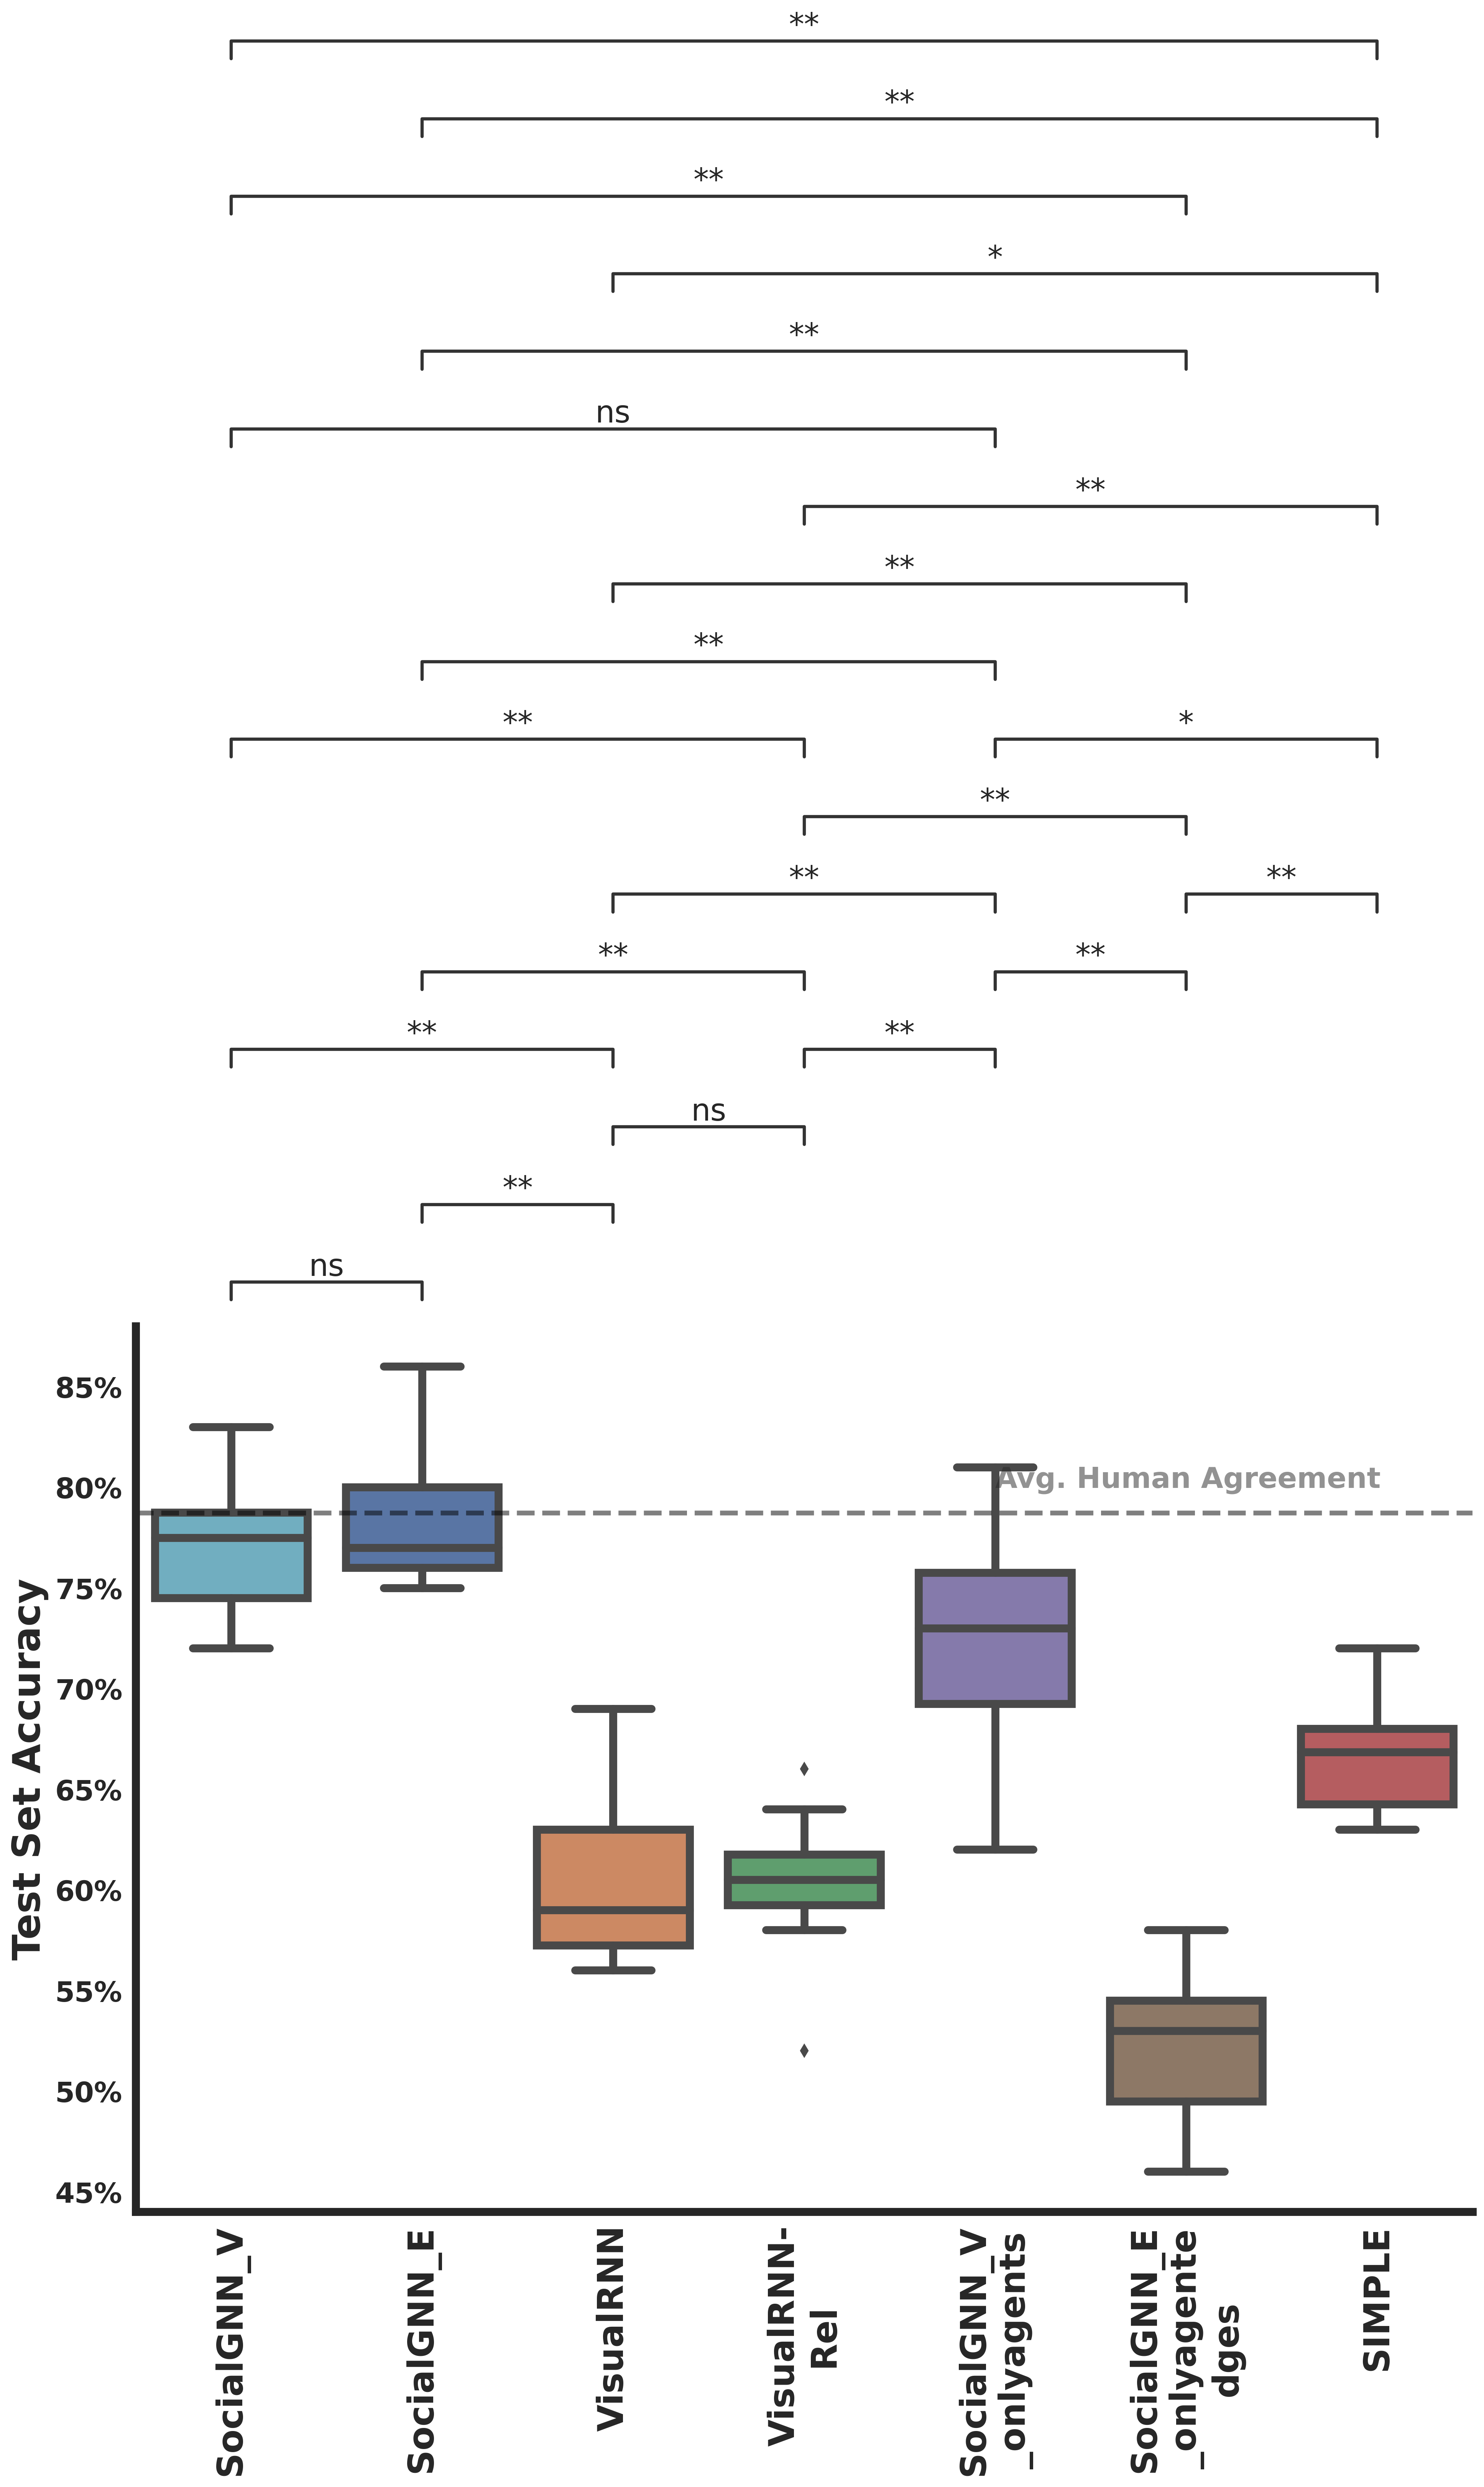

In [18]:
from statannotations.stats.StatTest import StatTest
from statannotations.Annotator import Annotator
from scipy.stats import permutation_test

def paired_mean_difference(data2, data1):
    return np.mean(np.array(data2) - np.array(data1))

df = pd.concat([pd.DataFrame(SocialGNN_V), pd.DataFrame(SocialGNN_E), pd.DataFrame(CueBasedLSTM_6), pd.DataFrame(CueBasedLSTM_Relation_6), pd.DataFrame(SocialGNN_V_onlyagents), pd.DataFrame(SocialGNN_E_onlyagentedges), pd.DataFrame(SIMPLE)], keys=['SocialGNN_V', 'SocialGNN_E', 'VisualRNN', 'VisualRNN-Rel', 'SocialGNN_V_onlyagents', 'SocialGNN_E_onlyagentedges', 'SIMPLE']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")
plt.rcParams["figure.figsize"] = (15,10)

p = [(0.39215686274509803, 0.7098039215686275, 0.803921568627451), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),  (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373), (0.8, 0.7254901960784313, 0.4549019607843137)]
f = sns.boxplot(x="model",y="testset_accuracy", data=df, linewidth=5, palette = p)
#f.axhline(0.33, color = "black", ls = "--", alpha = 0.5)
f.axhline(0.7872, color = "black", ls = "--", alpha = 0.5, linewidth = 3)
f.text(4, 0.8, "Avg. Human Agreement", fontsize=18, weight="bold", alpha = 0.5) #, bbox=dict(facecolor='red', alpha=0.5))

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 11) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 90, weight = "bold", fontsize=22)
f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=24)


# Significance testing
from itertools import combinations
order = ['SocialGNN_V', 'SocialGNN_E', 'VisualRNN', 'VisualRNN-Rel', 'SocialGNN_V_onlyagents', 'SocialGNN_E_onlyagentedges', 'SIMPLE']
pairs = list(combinations(order, 2))
annotator = Annotator(f, pairs, data=df, x="model", y="testset_accuracy", order=order)
pvalues = []
for pair in pairs:
    data1 = df.groupby('model')['testset_accuracy'].get_group(pair[0])
    data2 = df.groupby('model')['testset_accuracy'].get_group(pair[1])
    res = permutation_test((data1, data2), statistic=paired_mean_difference, permutation_type='samples', n_resamples=10000)
    pvalues.append(res.pvalue)
(annotator
 .configure(comparisons_correction="fdr_bh", test=None, test_short_name='permuation_test', text_format='star', loc='outside', line_width = 2, line_offset=0.01, text_offset=0.01)
 .set_pvalues(pvalues=pvalues)
 .annotate())

sns.despine()
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

from google.colab import files
plt.savefig("PHASE_ablationmodels.png", bbox_inches = 'tight', transparent = True)
#files.download("PHASE_ablationmodels.png")

plt.show()

# **PHASE Generalization Set**

## Load Model Predictions, Human Ratings, PHASE Labels

SIMPLE, SocialGNN and VisualRNN Predictions

In [ ]:
f = open('./SIMPLE-new-main/SIMPLE_predicted_labels_test', 'r')
entries = f.read().splitlines()

predictions = []

for e in range(1,600,6):
  v = dict()
  v['name'] = entries[e].split("/")[2][:23]
  v['inference'] = entries[e+2].split(" ")[2]
  v['gt'] = entries[e+4].split(" ")[2]
  predictions.append(v)

import pandas as pd
SIMPLE = pd.DataFrame(predictions)

#SIMPLE['correct'] = SIMPLE.apply(lambda x: 1 if x['inference']==x['gt'] else 0, axis = 1)
#print(sum(SIMPLE['correct']))
display(SIMPLE)

SIMPLE_dict = SIMPLE.set_index('name').T.to_dict('dict')


import pickle
#with open('./Predictions/PHASE_originalsplit_withcontext_June28_SocialGNN_E', "rb") as f:
with open('./Predictions/PHASE_originalsplit_contextTrue_20230515_SocialGNN_E_20230703', "rb") as f:
  true = pickle.load(f)
  pred = pickle.load(f)

pred_SocialGNN = {}
for v,label in pred.items():
  pred_SocialGNN[v[:23]] = label


with open('./Predictions/PHASE_originalsplit_withcontext_June28_CueBasedLSTM', "rb") as f:
  true = pickle.load(f)
  pred = pickle.load(f)

pred_CueBasedLSTM = {}
for v,label in pred.items():
  pred_CueBasedLSTM[v[:23]] = label

len(pred_SocialGNN), len(pred_CueBasedLSTM)

,name,inference,gt
0,D081920_0035030_0_F8_E8,friendly,friendly
1,D081920_1135270_0_F8_E1,friendly,friendly
2,D082020_1817530_0_F8_E8,friendly,friendly
3,D082120_0315260_0_F8_E1,friendly,friendly
4,D082120_1315000_0_F8_E7,neutral,adversarial
...,...,...,...
95,D083120_1954500_0_F8_E1,friendly,friendly
96,D090120_1849520_0_F8_E4,adversarial,adversarial
97,D090220_0310200_0_F8_E1,adversarial,adversarial
98,D090220_1953260_0_F8_E9,adversarial,adversarial


(100, 100)

Human Ratings: Labels and Agreement

In [ ]:
with open('./SocialGNN_Final/Human_Experiment_Files/human_rating_labels_agreement_test', 'rb') as file:
  HR_agreement_dict = pickle.load(file)

temp = {}
for k,v in HR_agreement_dict.items():
  temp[k[:24]] = v['relationship']

HR_agreement_dict = temp

with open('./SocialGNN_Final/Human_Experiment_Files/human_rating_labels_test', 'rb') as file:
    human_ratings_labels_dict = pickle.load(file)


PHASE labels (social goals used to generate videos) + PHASE HR

In [ ]:
import os
path = './SocialGNN_Final/PHASE/test'
n_videos = len(os.listdir(path))


import json
from collections import Counter
import pandas as pd
from scipy import stats

f = open("./individual_ans.json", "rb")

data = json.load(f)
print("Number of subjects: ",len(data))

data_filtered = {'videos':[], 'relationship':[]}

realness_rating = {'videos':[], 'realness':[]}

for participant in data:
  for row in participant:
    if 'question' in row.keys() and row['question']=='What is the relationship?':
      data_filtered['videos'].append(row['name'])
      data_filtered['relationship'].append(row['value'])
    if 'question' in row.keys() and row['question']=='Would a human do the same?':
      realness_rating['videos'].append(row['name'])
      realness_rating['realness'].append(row['value'])

data = pd.DataFrame(data_filtered)
HR_PHASE = data.groupby(by='videos').agg(lambda x: stats.mode(x)[0][0])
HR_PHASE.index = HR_PHASE.index.str[:51]
HR_PHASE_dict = HR_PHASE.to_dict('index')
HR_PHASE

Number of subjects:  100


<ipython-input-6-30073f9ceb0a>:30: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  HR_PHASE = data.groupby(by='videos').agg(lambda x: stats.mode(x)[0][0])


,relationship
videos,
"D081920_0035030_G['LMO', 0, 3, 1]_['LMO', 0, 3, 1]_",Friendly
"D081920_1135270_G['LMO', 0, 3, 1]_['LMO', 0, 3, 1]_",Friendly
"D082020_1817530_G['LMO', 0, 0, 1]_['LMO', 0, 0, 1]_",Friendly
"D082120_0315260_G['LMO', 1, 1, 1]_['LMO', 1, 1, 1]_",Friendly
"D082120_1315000_G['LMA', 0, 0, 1]_['LMA', 0, 0, -1]",Adversarial
...,...
"D083120_1954500_G['LMO', 0, 1, 1]_['LMO', 0, 1, 1]_",Friendly
"D090120_1849520_G['LMO', 1, 0, 1]_['LMO', 1, 1, 1]_",Adversarial
"D090220_0310200_G['LMO', 1, 0, 1]_['LMO', 1, 2, 1]_",Adversarial


## Combining our HR, PHASE HR, SIMPLE GT, PHASE GT, our pred, VisualRRN pred, SIMPLE pred

In [ ]:
import numpy as np

names = []
GT = []
HR = []
HR_PHASE = []
GT_SIMPLE = []
Pred_SIMPLE = []
Pred_SocialGNN = []
Pred_CueBasedLSTM = []

mapping = {'Friendly':'friendly', "Neutral":'neutral', 'Adversarial':'adversarial'}
for root, dirs, files, in os.walk(path):
  for file in files:
    if file.endswith(".pik"):
      open_f = open(path + '/' + file, 'rb')
      open_f_data = pickle.load(open_f)
      v = {}
      v['name'] = file[:-3] + 'mp4'
      names.append(v['name'])

      GT.append(open_f_data['modes'][0][0])
      HR.append(human_ratings_labels_dict[v['name']]['relationship'])

      ind = file.find('G')
      f_name = file[:15]+ file[ind-1:ind+35]
      HR_PHASE.append(mapping[HR_PHASE_dict[f_name]['relationship']])

      GT_SIMPLE.append(SIMPLE_dict[file[:23]]['gt'])

      Pred_SIMPLE.append(SIMPLE_dict[file[:23]]['inference'])
      Pred_SocialGNN.append(pred_SocialGNN[file[:23]])
      Pred_CueBasedLSTM.append(pred_CueBasedLSTM[file[:23]])


print("GT", Counter(GT))
print("HR", Counter(HR))
print("HR_PHASE", Counter(HR_PHASE))
print("GT_SIMPLE", Counter(GT_SIMPLE))

print("Pred SIMPLE", Counter(Pred_SIMPLE))
print("Pred SocialGNN", Counter(Pred_SocialGNN))
print("Pred VisualRNN", Counter(Pred_CueBasedLSTM))

# Note: possibly stats.mode changed slightly, so we see a small difference here in HR_PHASE distribution as compared to when this was run earlier

GT Counter({'neutral': 62, 'friendly': 21, 'adversarial': 17})
HR Counter({'friendly': 37, 'adversarial': 36, 'neutral': 27})
HR_PHASE Counter({'adversarial': 37, 'friendly': 37, 'neutral': 26})
GT_SIMPLE Counter({'friendly': 37, 'adversarial': 36, 'neutral': 27})
Pred SIMPLE Counter({'adversarial': 40, 'friendly': 34, 'neutral': 26})
Pred SocialGNN Counter({'friendly': 48, 'adversarial': 28, 'neutral': 24})
Pred VisualRNN Counter({'friendly': 56, 'adversarial': 36, 'neutral': 8})


## Accuracy Plot

,model,testset_accuracy
0,SocialGNN,0.76
1,VisualRNN,0.48
2,Inverse Planning (SIMPLE),0.83


<ipython-input-38-6dd3857f1f07>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_yticklabels(),rotation = 0, weight = "bold")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

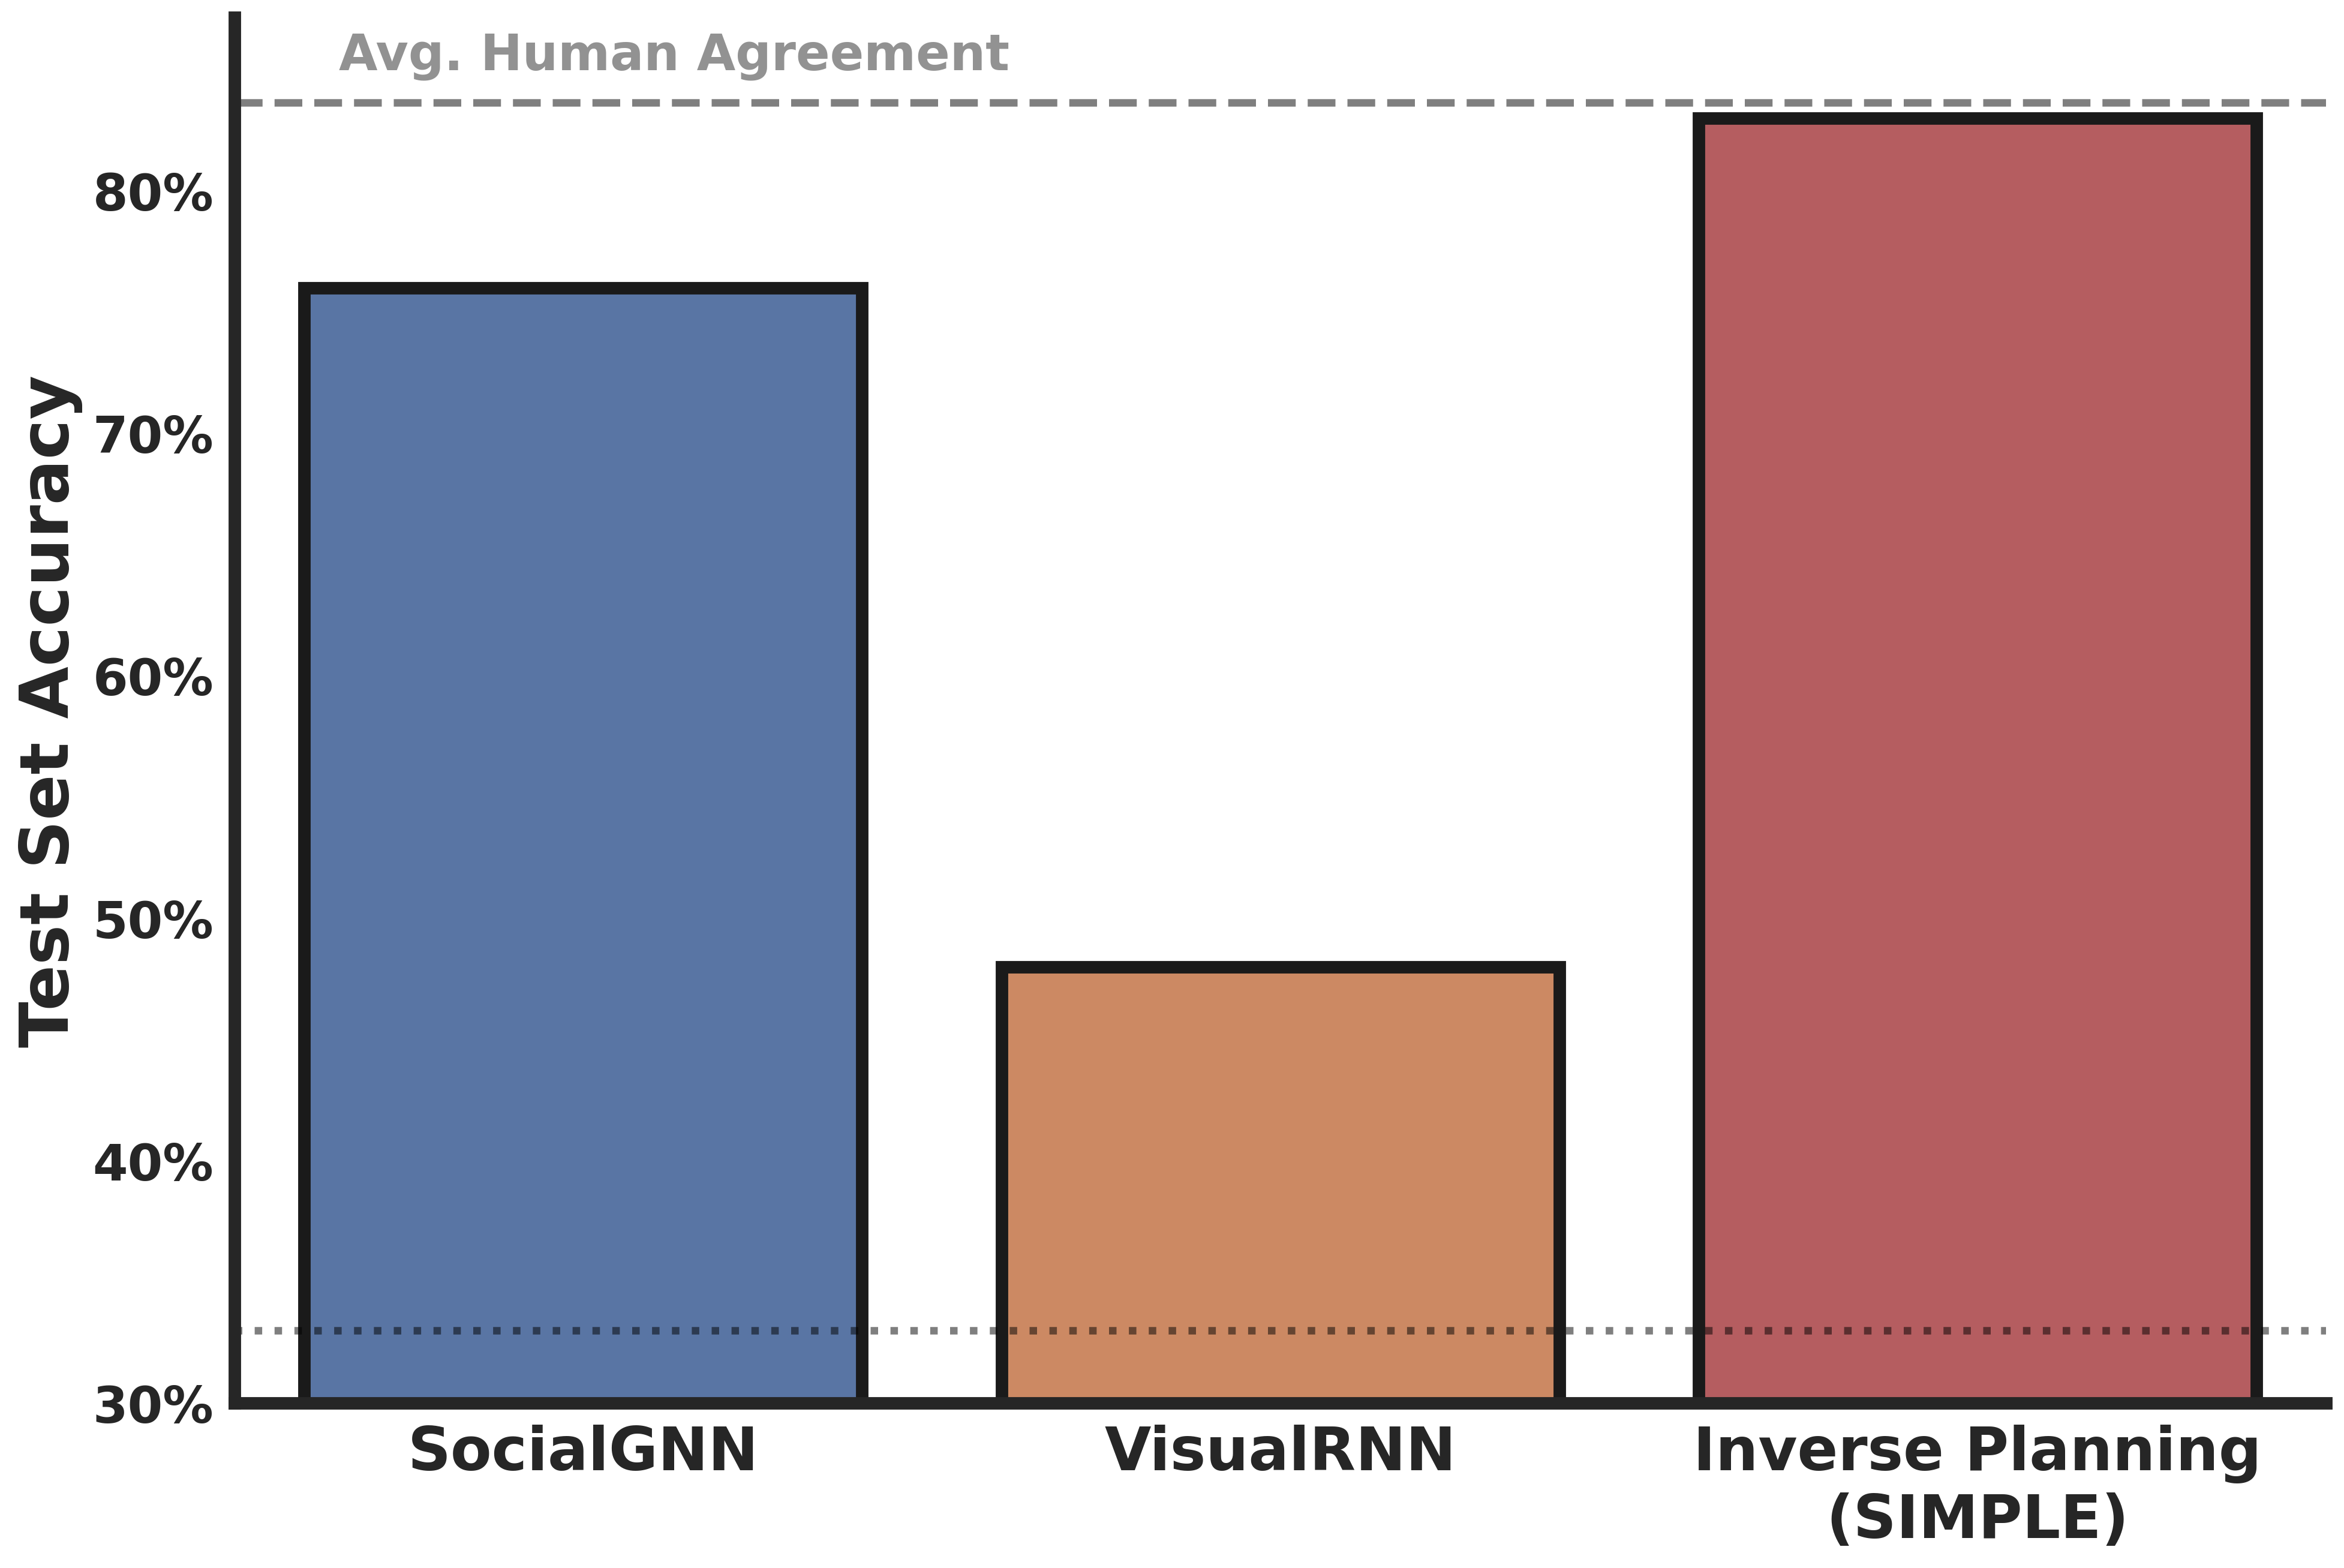

In [ ]:
#(added wall and landmark coordinates)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

'''
SocialGNN_E_16 = {'testset': [0.76]}
CueBasedLSTM_16 = {'testset': [0.48]}
SIMPLE = {'testset': [0.9]}
'''

SocialGNN_E_16 = {'testset': [acc['SocialGNN']['HR']]}
CueBasedLSTM_16 = {'testset': [acc['CueBasedLSTM']['HR']]}
SIMPLE = {'testset': [acc['SIMPLE']['HR']]}

df = pd.concat([pd.DataFrame(SocialGNN_E_16), pd.DataFrame(CueBasedLSTM_16), pd.DataFrame(SIMPLE)], keys=['SocialGNN', 'VisualRNN', 'Inverse Planning (SIMPLE)']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)
display(df)

# Plots
#sns.set(rc={'figure.figsize':(20,14), 'font.weight':'normal'}, font_scale=3, style = "white")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2.3, style="white")
plt.rcParams["figure.figsize"] = (15,10)

p = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]
f = sns.barplot(x="model",y="testset_accuracy", data=df, palette = p, linewidth = 5, edgecolor ='k')

f.axhline(0.33, color = "black", ls = ":", alpha = 0.5, linewidth = 3)
f.axhline(0.8363, color = "black", ls = "--", alpha = 0.5, linewidth = 3)
f.text(-.35, 0.85, "Avg. Human Agreement", fontsize=20, weight="bold", alpha = 0.5)

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 20) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=24)
f.set_yticklabels(f.get_yticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=27)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.gca().set_ylim(bottom=0.3)

sns.despine()
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from google.colab import files
plt.savefig("PHASE_generalisationset.png", bbox_inches = 'tight', transparent = True)
#files.download("PHASE_generalisationset.png")

plt.show()

## Computational Resources Plot

In [ ]:
# time in sec, memory is in MB
SocialGNN_E_25 = {'run_time' : 16, 'memory': 1.32}
CueBasedLSTM_6_25 = {'run_time' : 4, 'memory': 1.32}
SIMPLE_25 = {'run_time' : 98513, 'memory': 48280}   # this is 27hrs, 21.9mins

mydicts = [SocialGNN_E_25, CueBasedLSTM_6_25, SIMPLE_25]

df = pd.DataFrame.from_records(mydicts).fillna(0)
df.index = ['SocialGNN', 'VisualRNN', 'Inverse Planning']
display(df)

# is the _25 just rnadom naming to make it distinct from accruacy dictionaries??

,run_time,memory
SocialGNN,16,1.32
VisualRNN,4,1.32
Inverse Planning,98513,48280.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

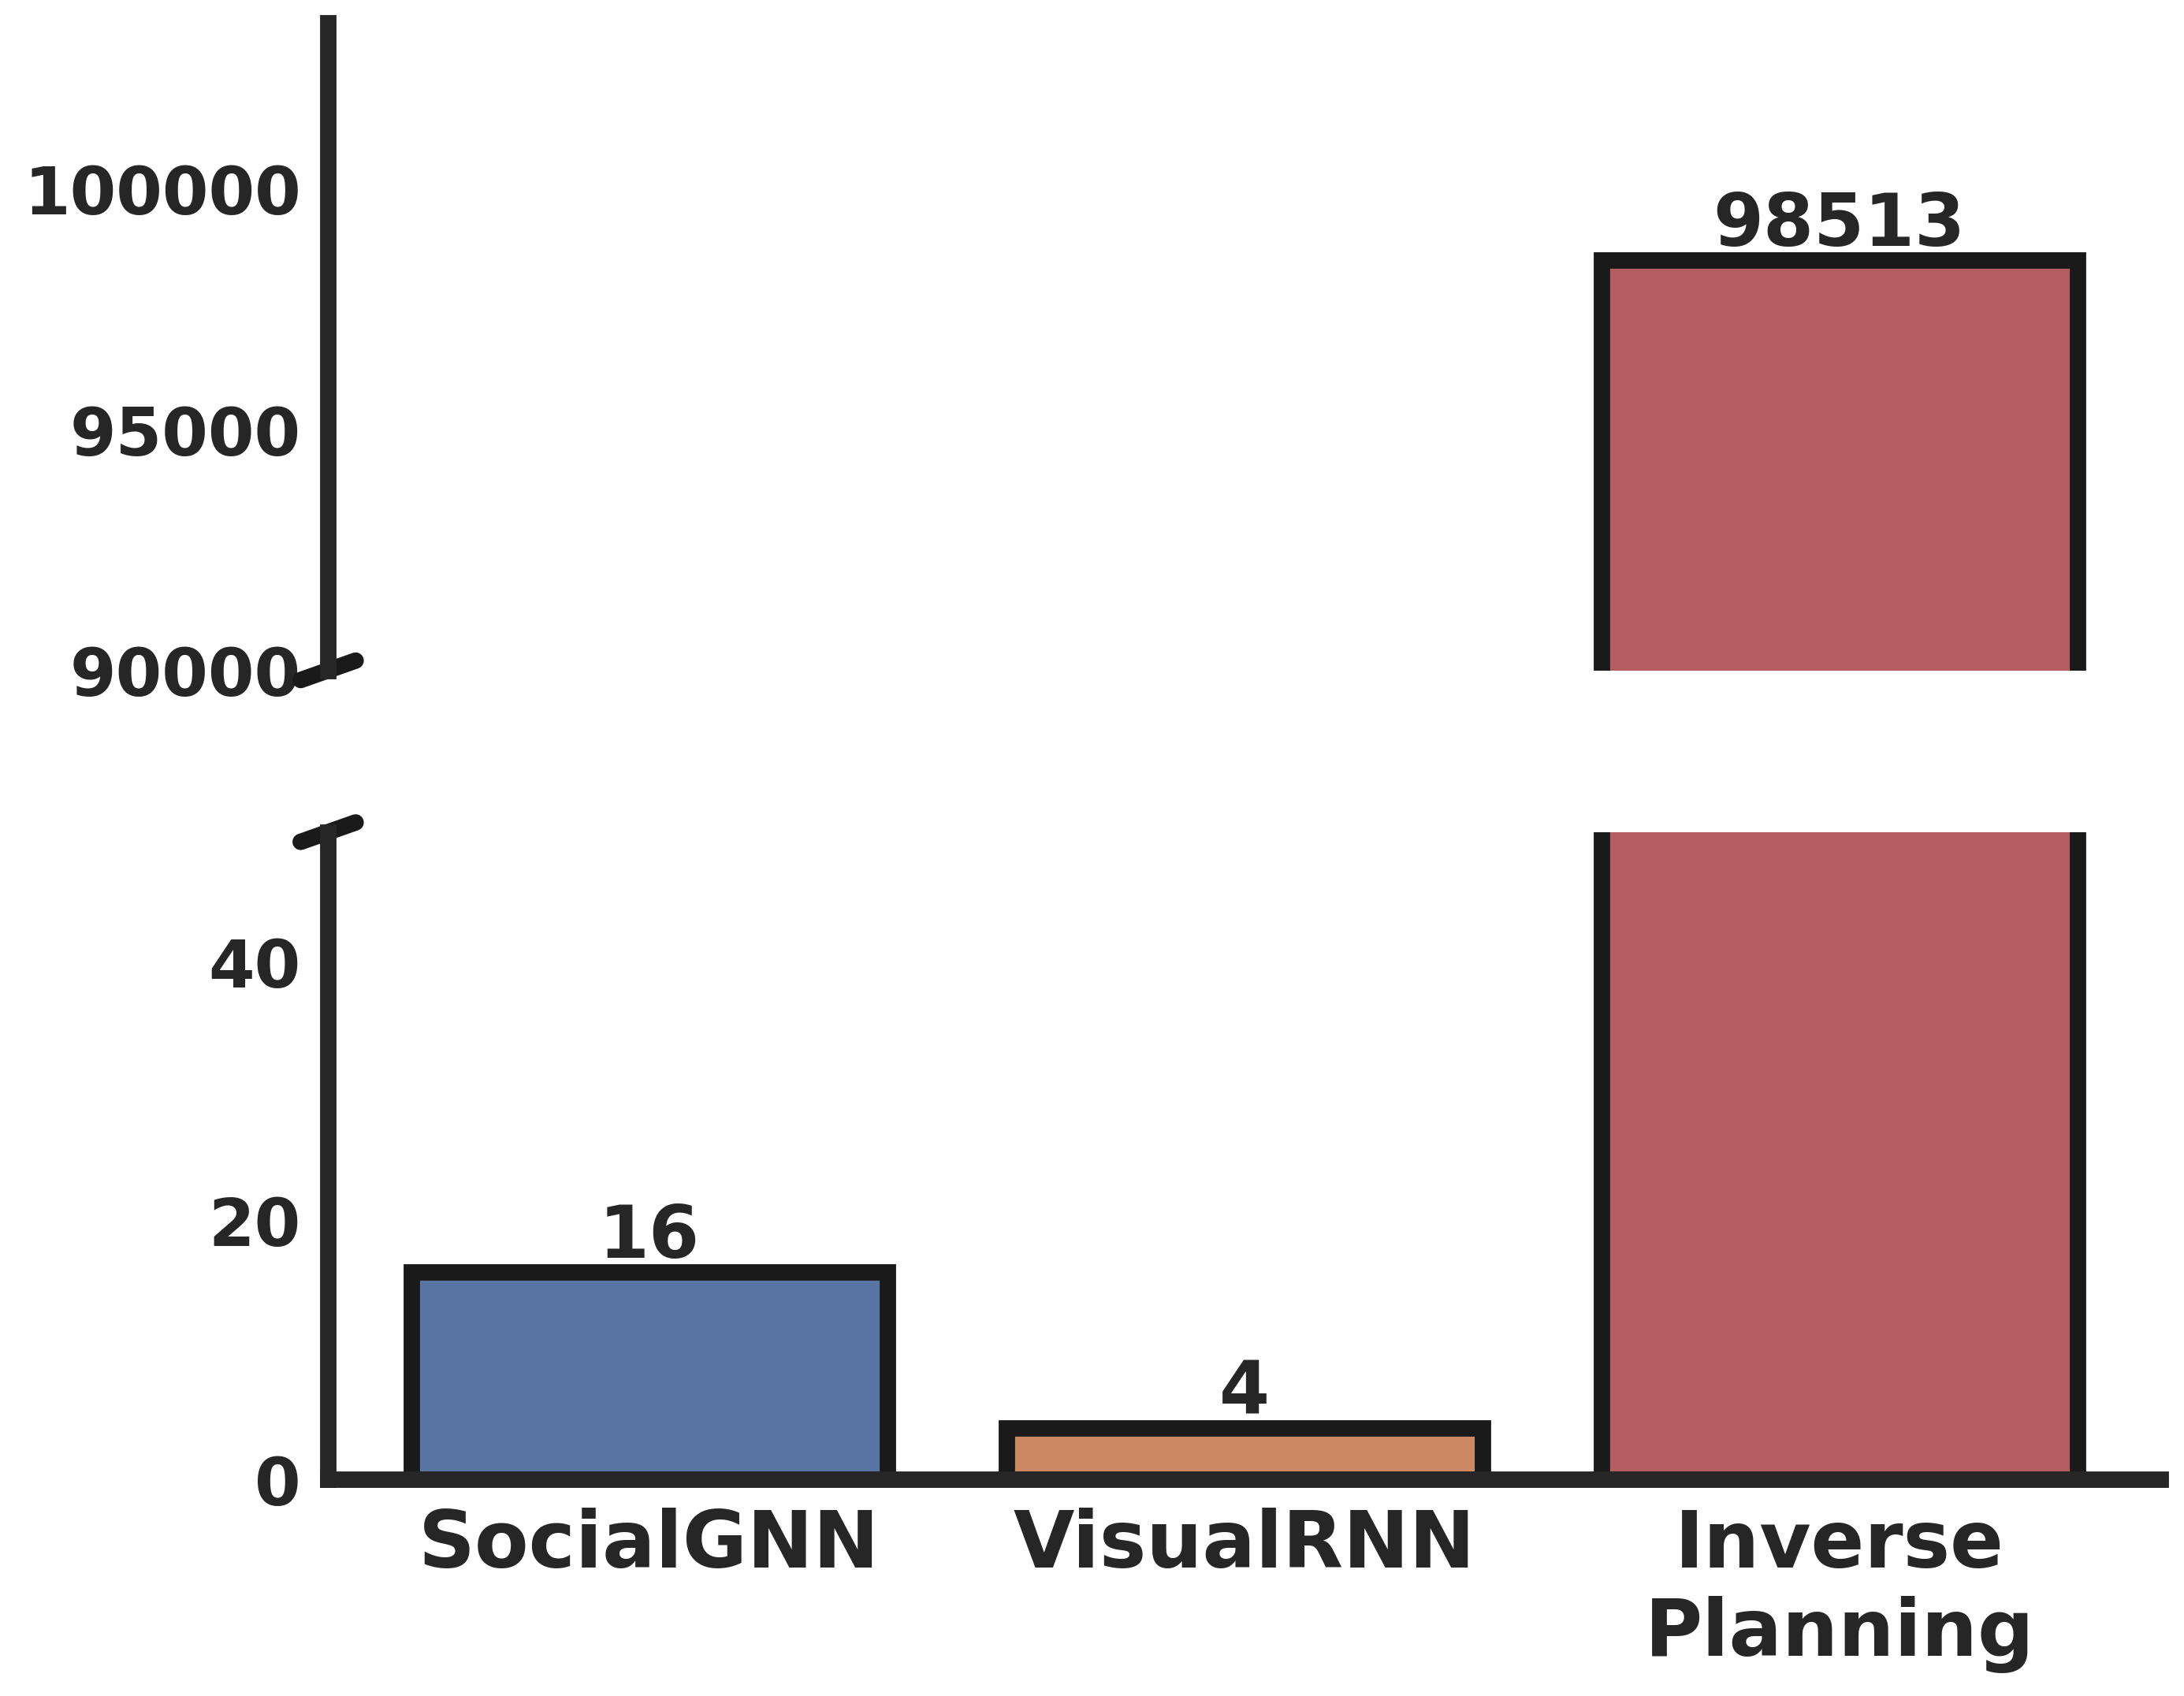

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

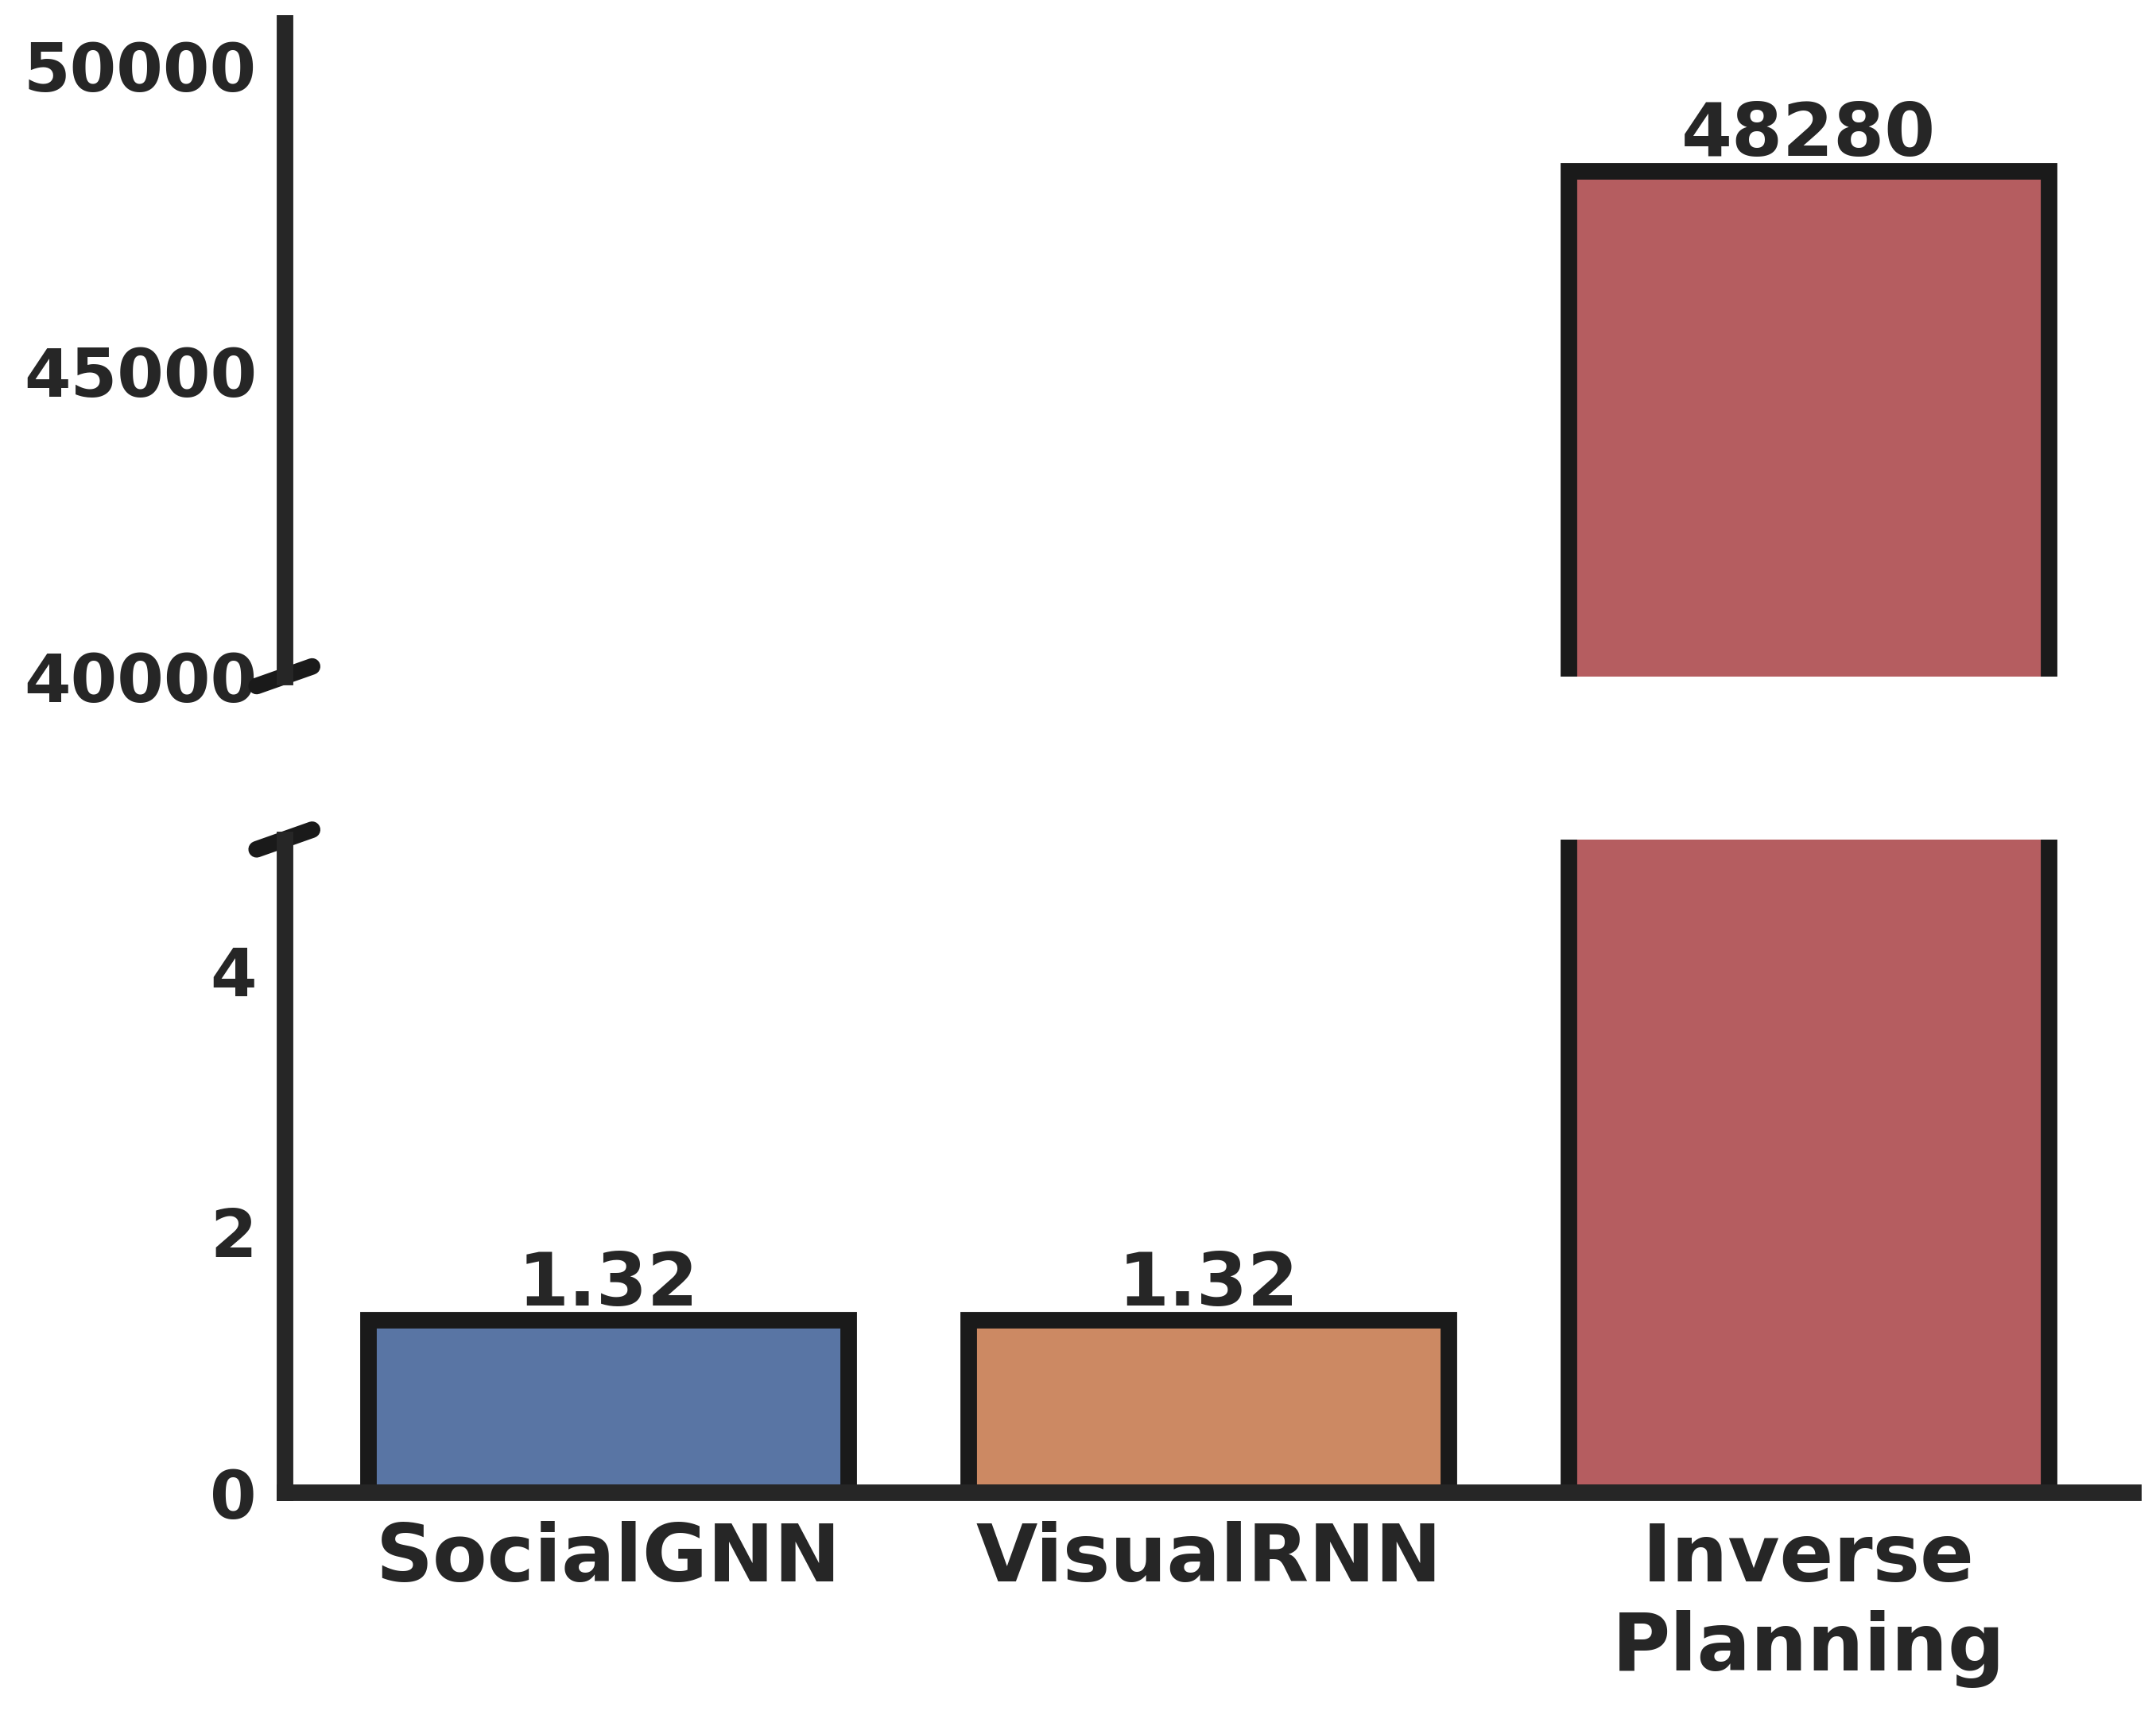

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2.3, style="white")
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["font.weight"] = "bold"

### Run Time
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.25})
p = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]
a = sns.barplot(x = df.index, y="run_time", data=df, ax=ax_top, palette = p, linewidth = 5, edgecolor ='k')
b = sns.barplot(x = df.index, y="run_time", data=df, ax=ax_bottom, palette = p, linewidth = 5, edgecolor ='k')
a.bar_label(a.containers[0], fontweight = "bold")
b.bar_label(b.containers[0], fontweight = "bold")
ax_top.set_ylim(bottom=90000)
ax_bottom.set_ylim(0,50)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)
ax_top.spines['left'].set_linewidth(5)
ax_bottom.spines['left'].set_linewidth(5)
ax_bottom.spines['bottom'].set_linewidth(5)

ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linewidth = 5)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

a.set(xlabel=None)
b.set(xlabel=None)
a.set(ylabel=None)
b.set(ylabel=None)
#f.supylabel('Run-Time (sec)')

import textwrap
ax_bottom.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in ax_bottom.get_xticklabels())
ax_bottom.set_xticklabels(ax_bottom.get_xticklabels(),rotation = 0, weight = "bold", fontsize=24)

from google.colab import files
plt.savefig("run-time.svg", bbox_inches = 'tight', transparent = True)
#files.download("run-time.svg")
plt.show()


### Memory
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.25})
p = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]
a = sns.barplot(x = df.index, y="memory", data=df, ax=ax_top, palette = p, linewidth = 5, edgecolor ='k')
b = sns.barplot(x = df.index, y="memory", data=df, ax=ax_bottom, palette = p, linewidth = 5, edgecolor ='k')
a.bar_label(a.containers[0], fontweight = "bold")
b.bar_label(b.containers[0], fontweight = "bold")
ax_top.set_ylim(bottom=40000)
ax_bottom.set_ylim(0,5)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)
ax_top.spines['left'].set_linewidth(5)
ax_bottom.spines['left'].set_linewidth(5)
ax_bottom.spines['bottom'].set_linewidth(5)

ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linewidth=5)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

a.set(xlabel=None)
b.set(xlabel=None)
a.set(ylabel=None)
b.set(ylabel=None)
#f.supylabel('Run-Time (sec)')

import textwrap
ax_bottom.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in ax_bottom.get_xticklabels())
ax_bottom.set_xticklabels(ax_bottom.get_xticklabels(),rotation = 0, weight = "bold", fontsize=24)

from google.colab import files
plt.savefig("memory.svg", bbox_inches = 'tight', transparent = True)
#files.download("memory.svg")
plt.show()

# **Human Gaze Communication Dataset**

## 2 Way

In [ ]:
pip install statannotations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


<ipython-input-27-8fef763826f1>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SocialGNN vs. VisualRNN: Custom statistical test with Holm-Bonferroni correction, P_val:2.000e-04
VisualRNN-Rel vs. VGG19: Custom statistical test with Holm-Bonferroni correction, P_val:2.800e-03
SocialGNN vs. VisualRNN-Rel: Custom statistical test with Holm-Bonferroni correction, P_val:2.000e-04
VisualRNN vs. VGG19: Custom statistical test with Holm-Bonferroni correction, P_val:2.000e-04
SocialGNN vs. VGG19: Custom statistical test with Holm-Bonferroni correction, P_val:2.000e-04


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

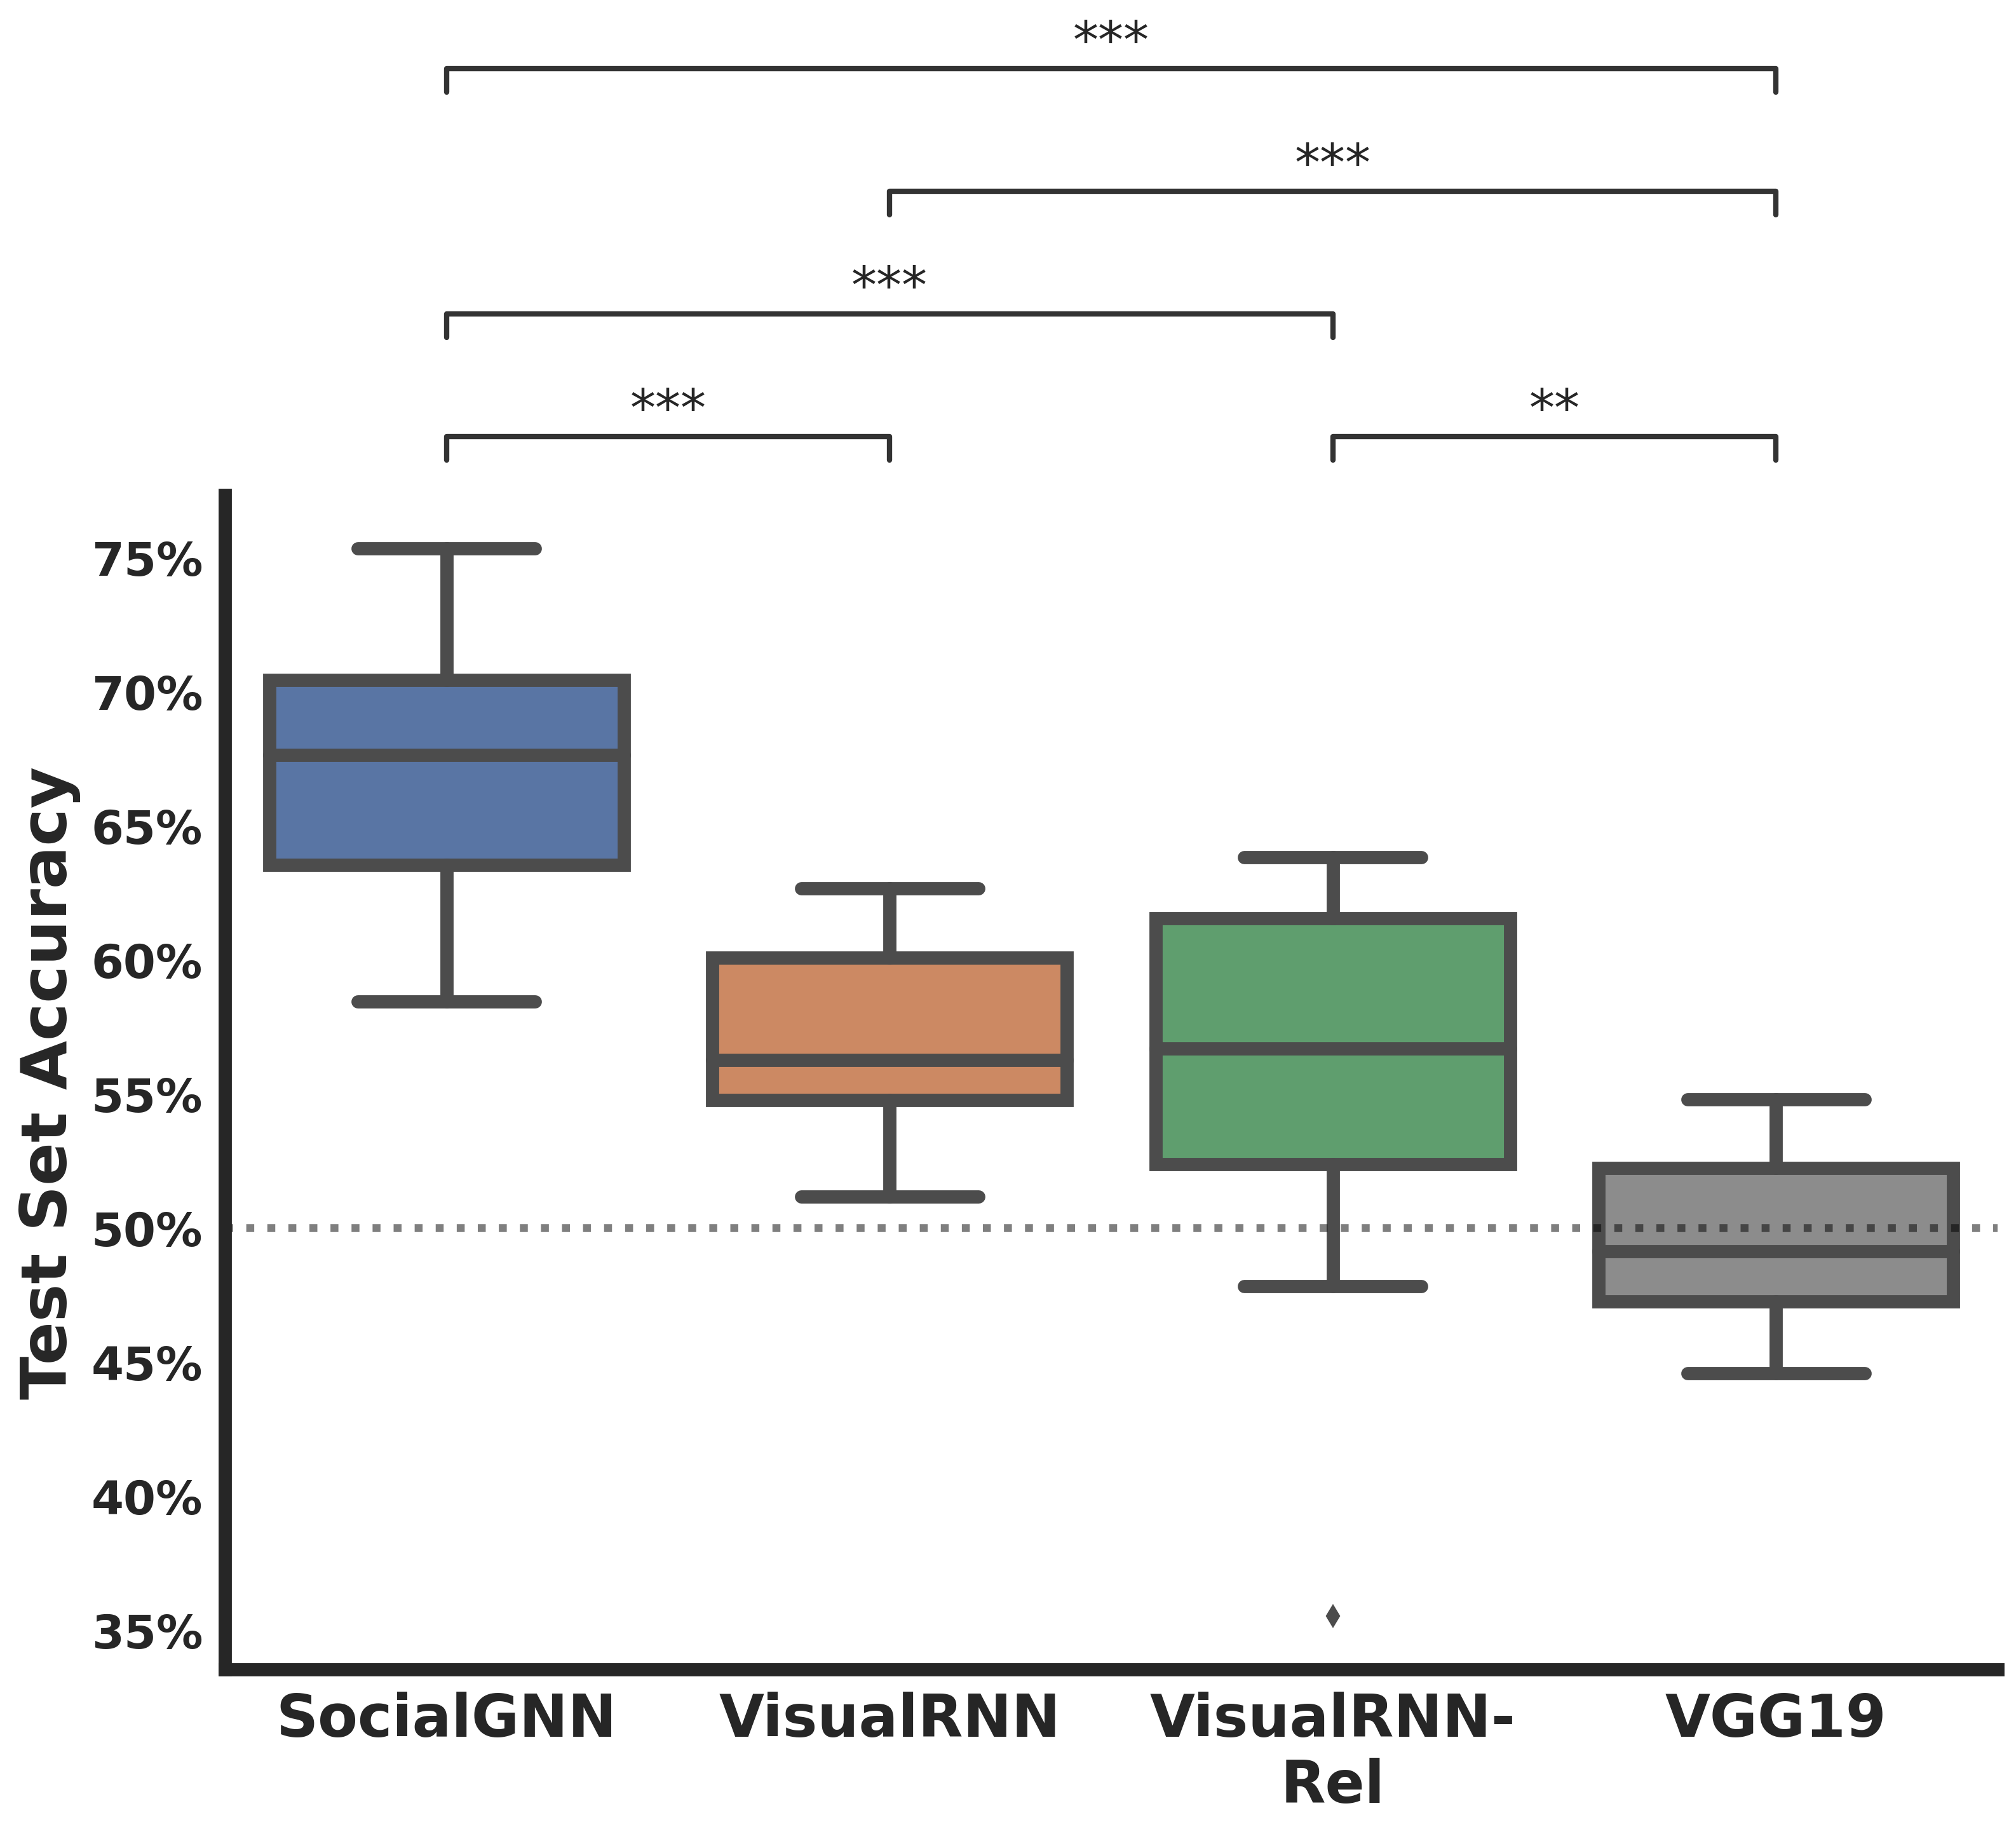

In [ ]:
#combined 5thJun and 14Jun all 4 models (1e-3)
SocialGNN_V_5 = {'cross_val': [0.6612244897959184, 0.651798561151079, 0.687615320100643, 0.6251723104584956, 0.6415304676428909, 0.5971830985915493, 0.7166666666666667, 0.6406631216765717, 0.7102227192246762, 0.6309859154929577], 'entire_trainset': [0.7442176870748299, 0.7707736389684814, 0.781718963165075, 0.7383309759547383, 0.7898351648351648, 0.6915492957746479, 0.8208333333333333, 0.784992784992785, 0.7841530054644809, 0.7225352112676057], 'testset': [0.7375565610859729, 0.5930232558139535, 0.7533632286995515, 0.6305220883534136, 0.7280701754385965, 0.7032520325203252, 0.6822033898305084, 0.6425855513307985, 0.6830357142857143, 0.6951219512195121]}
SocialGNN_V_14 = {'cross_val': [0.7308520971302428, 0.6542654700047237, 0.6811399742378703, 0.660431654676259, 0.730266706622715, 0.6246376811594203, 0.6748563218390806, 0.6256609195402298, 0.6671529888551165, 0.647887323943662], 'entire_trainset': [0.7997347480106101, 0.7121212121212122, 0.6681286549707602, 0.8014388489208633, 0.75, 0.6985507246376812, 0.8312586445366529, 0.7058011049723757, 0.7027027027027027, 0.7309859154929578], 'testset': [0.7079207920792079, 0.6826086956521739, 0.5845588235294118, 0.6704980842911877, 0.6370967741935484, 0.6278195488721805, 0.7167381974248928, 0.6508620689655172, 0.6403162055335968, 0.6178861788617886]}
SocialGNN_V = {'testset': SocialGNN_V_5['testset']+SocialGNN_V_14['testset']}
CueBasedLSTM_6_5 = {'cross_val': [0.5414965986394558, 0.5615416238437821, 0.5701705339670113, 0.537438817300969, 0.5603873405762873, 0.5309859154929577, 0.5791666666666666, 0.587279741424252, 0.5190010250675613, 0.6084507042253521], 'entire_trainset': [0.6040816326530613, 0.7191977077363897, 0.6521145975443383, 0.6308345120226309, 0.6222527472527473, 0.6943661971830986, 0.7666666666666667, 0.6753246753246753, 0.6557377049180327, 0.6887323943661972], 'testset': [0.5158371040723982, 0.5116279069767442, 0.600896860986547, 0.5502008032128514, 0.6008771929824561, 0.6260162601626016, 0.6016949152542372, 0.5551330798479087, 0.53125, 0.5934959349593496]}
CueBasedLSTM_6_14 = {'cross_val': [0.54639293598234, 0.5840245630609353, 0.5014598540145986, 0.5841726618705035, 0.5561881929877136, 0.5695652173913043, 0.5409961685823754, 0.5952394636015326, 0.60177304964539, 0.5816901408450704], 'entire_trainset': [0.6763925729442971, 0.6680440771349863, 0.7076023391812866, 0.5956834532374101, 0.6271186440677966, 0.7260869565217392, 0.690179806362379, 0.7044198895027625, 0.6330014224751067, 0.6676056338028169], 'testset': [0.5544554455445545, 0.5652173913043478, 0.5404411764705882, 0.6245210727969349, 0.5161290322580645, 0.5601503759398496, 0.6266094420600858, 0.5862068965517241, 0.5533596837944664, 0.5772357723577236]}
CueBasedLSTM_6 = {'testset': CueBasedLSTM_6_5['testset']+CueBasedLSTM_6_14['testset']}
CueBasedLSTM_Relation_6_5 = {'cross_val': [0.5346938775510204, 0.5644193216855088, 0.5866461653154412, 0.5487264009589452, 0.5396315540859707, 0.532394366197183, 0.548611111111111, 0.5946095297674903, 0.5369956201658745, 0.5577464788732394], 'entire_trainset': [0.6639455782312925, 0.7464183381088825, 0.6248294679399727, 0.669024045261669, 0.40796703296703296, 0.723943661971831, 0.6611111111111111, 0.7518037518037518, 0.6297814207650273, 0.7112676056338029], 'testset': [0.6153846153846154, 0.5155038759689923, 0.547085201793722, 0.6345381526104418, 0.35526315789473684, 0.6382113821138211, 0.635593220338983, 0.5855513307984791, 0.6160714285714286, 0.6178861788617886]}
CueBasedLSTM_Relation_6_14 = {'cross_val': [0.5291567328918323, 0.5674917335852622, 0.5117217689995706, 0.5611510791366906, 0.5776845469983019, 0.5594202898550724, 0.5187643678160919, 0.5606992337164751, 0.5945491388044579, 0.5577464788732395], 'entire_trainset': [0.6061007957559682, 0.49449035812672176, 0.6681286549707602, 0.6964028776978417, 0.7358757062146892, 0.7623188405797101, 0.6445366528354081, 0.7348066298342542, 0.6813655761024182, 0.6366197183098592], 'testset': [0.48514851485148514, 0.4782608695652174, 0.5183823529411765, 0.5747126436781609, 0.5604838709677419, 0.5601503759398496, 0.6137339055793991, 0.5732758620689655, 0.525691699604743, 0.5447154471544715]}
CueBasedLSTM_Relation_6 = {'testset': CueBasedLSTM_Relation_6_5['testset']+CueBasedLSTM_Relation_6_14['testset']}
VGG19mod_5 = {'cross_val': [0.4258503401360544, 0.5042857142857142, 0.5006989097008667, 0.4610927979222854, 0.43273500236183277, 0.5112676056338028, 0.47777777777777775, 0.47032634761755815, 0.48349641226353557, 0.4985915492957746], 'entire_trainset': [0.8979591836734694, 0.8954154727793696, 0.9113233287858117, 0.8783592644978784, 0.8901098901098901, 0.9056338028169014, 0.9125, 0.8888888888888888, 0.8825136612021858, 0.895774647887324], 'testset': [0.4751131221719457, 0.44573643410852715, 0.515695067264574, 0.5220883534136547, 0.47368421052631576, 0.4878048780487805, 0.4872881355932203, 0.5057034220532319, 0.45089285714285715, 0.44715447154471544]}
VGG19mod_14 = {'cross_val': [0.3938631346578366, 0.4518658478979688, 0.4429154143409188, 0.4618705035971223, 0.4830486464888623, 0.43768115942028984, 0.4411877394636015, 0.46955938697318, 0.47933130699088144, 0.5014084507042254], 'entire_trainset': [0.8740053050397878, 0.8953168044077136, 0.8786549707602339, 0.8805755395683453, 0.8983050847457628, 0.8797101449275362, 0.8990318118948825, 0.8867403314917127, 0.8975817923186344, 0.9084507042253521], 'testset': [0.49504950495049505, 0.47391304347826085, 0.5404411764705882, 0.5478927203065134, 0.45161290322580644, 0.5451127819548872, 0.5236051502145923, 0.4698275862068966, 0.525691699604743, 0.5040650406504065]}
VGG19mod = {'testset': VGG19mod_5['testset']+VGG19mod_14['testset']}

from statannotations.stats.StatTest import StatTest
from statannotations.Annotator import Annotator
from scipy.stats import permutation_test
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def paired_mean_difference(data2, data1):
    return np.mean(np.array(data2) - np.array(data1))

df = pd.concat([pd.DataFrame(SocialGNN_V), pd.DataFrame(CueBasedLSTM_6), pd.DataFrame(CueBasedLSTM_Relation_6), pd.DataFrame(VGG19mod)], keys=['SocialGNN','VisualRNN', 'VisualRNN-Rel', 'VGG19']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")
plt.rcParams["figure.figsize"] = (12,8)

# color palette = deep
p = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)]
f = sns.boxplot(x="model",y="testset_accuracy", data=df, linewidth = 5, palette=p)
f.axhline(0.5, color = "black", ls = ":", alpha = 0.5, linewidth = 3) #alpha 0.8 for the poster

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=22)
f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=24)

# Significance testing
order = ['SocialGNN', 'VisualRNN', 'VisualRNN-Rel', 'VGG19']
pairs=[("SocialGNN", "VisualRNN"), ("SocialGNN", "VisualRNN-Rel"), ("SocialGNN", "VGG19"), ("VisualRNN", "VGG19"), ("VisualRNN-Rel", "VGG19")]
annotator = Annotator(f, pairs, data=df, x="model", y="testset_accuracy", order=order)
pvalues = []
for pair in pairs:
    data1 = df.groupby('model')['testset_accuracy'].get_group(pair[0])
    data2 = df.groupby('model')['testset_accuracy'].get_group(pair[1])
    res = permutation_test((data1, data2), statistic=paired_mean_difference, permutation_type='samples', n_resamples=10000)
    pvalues.append(res.pvalue)
(annotator
 .configure(comparisons_correction="HB", test=None, test_short_name='permuation_test', text_format='star', loc='outside', line_width = 2, line_offset=0.01, text_offset=0.01)
 .set_pvalues(pvalues=pvalues)
 .annotate())

sns.despine()
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

from google.colab import files
plt.savefig("gaze_2.png", bbox_inches = 'tight', transparent = False)
#files.download("gaze_2.png")

plt.show()

## 5-way

<ipython-input-6-6a33c4aca5a1>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SocialGNN vs. VisualRNN: Custom statistical test with Holm-Bonferroni correction, P_val:2.000e-04
SocialGNN vs. VisualRNN-Rel: Custom statistical test with Holm-Bonferroni correction, P_val:2.000e-04
SocialGNN vs. VGG19: Custom statistical test with Holm-Bonferroni correction, P_val:4.000e-04


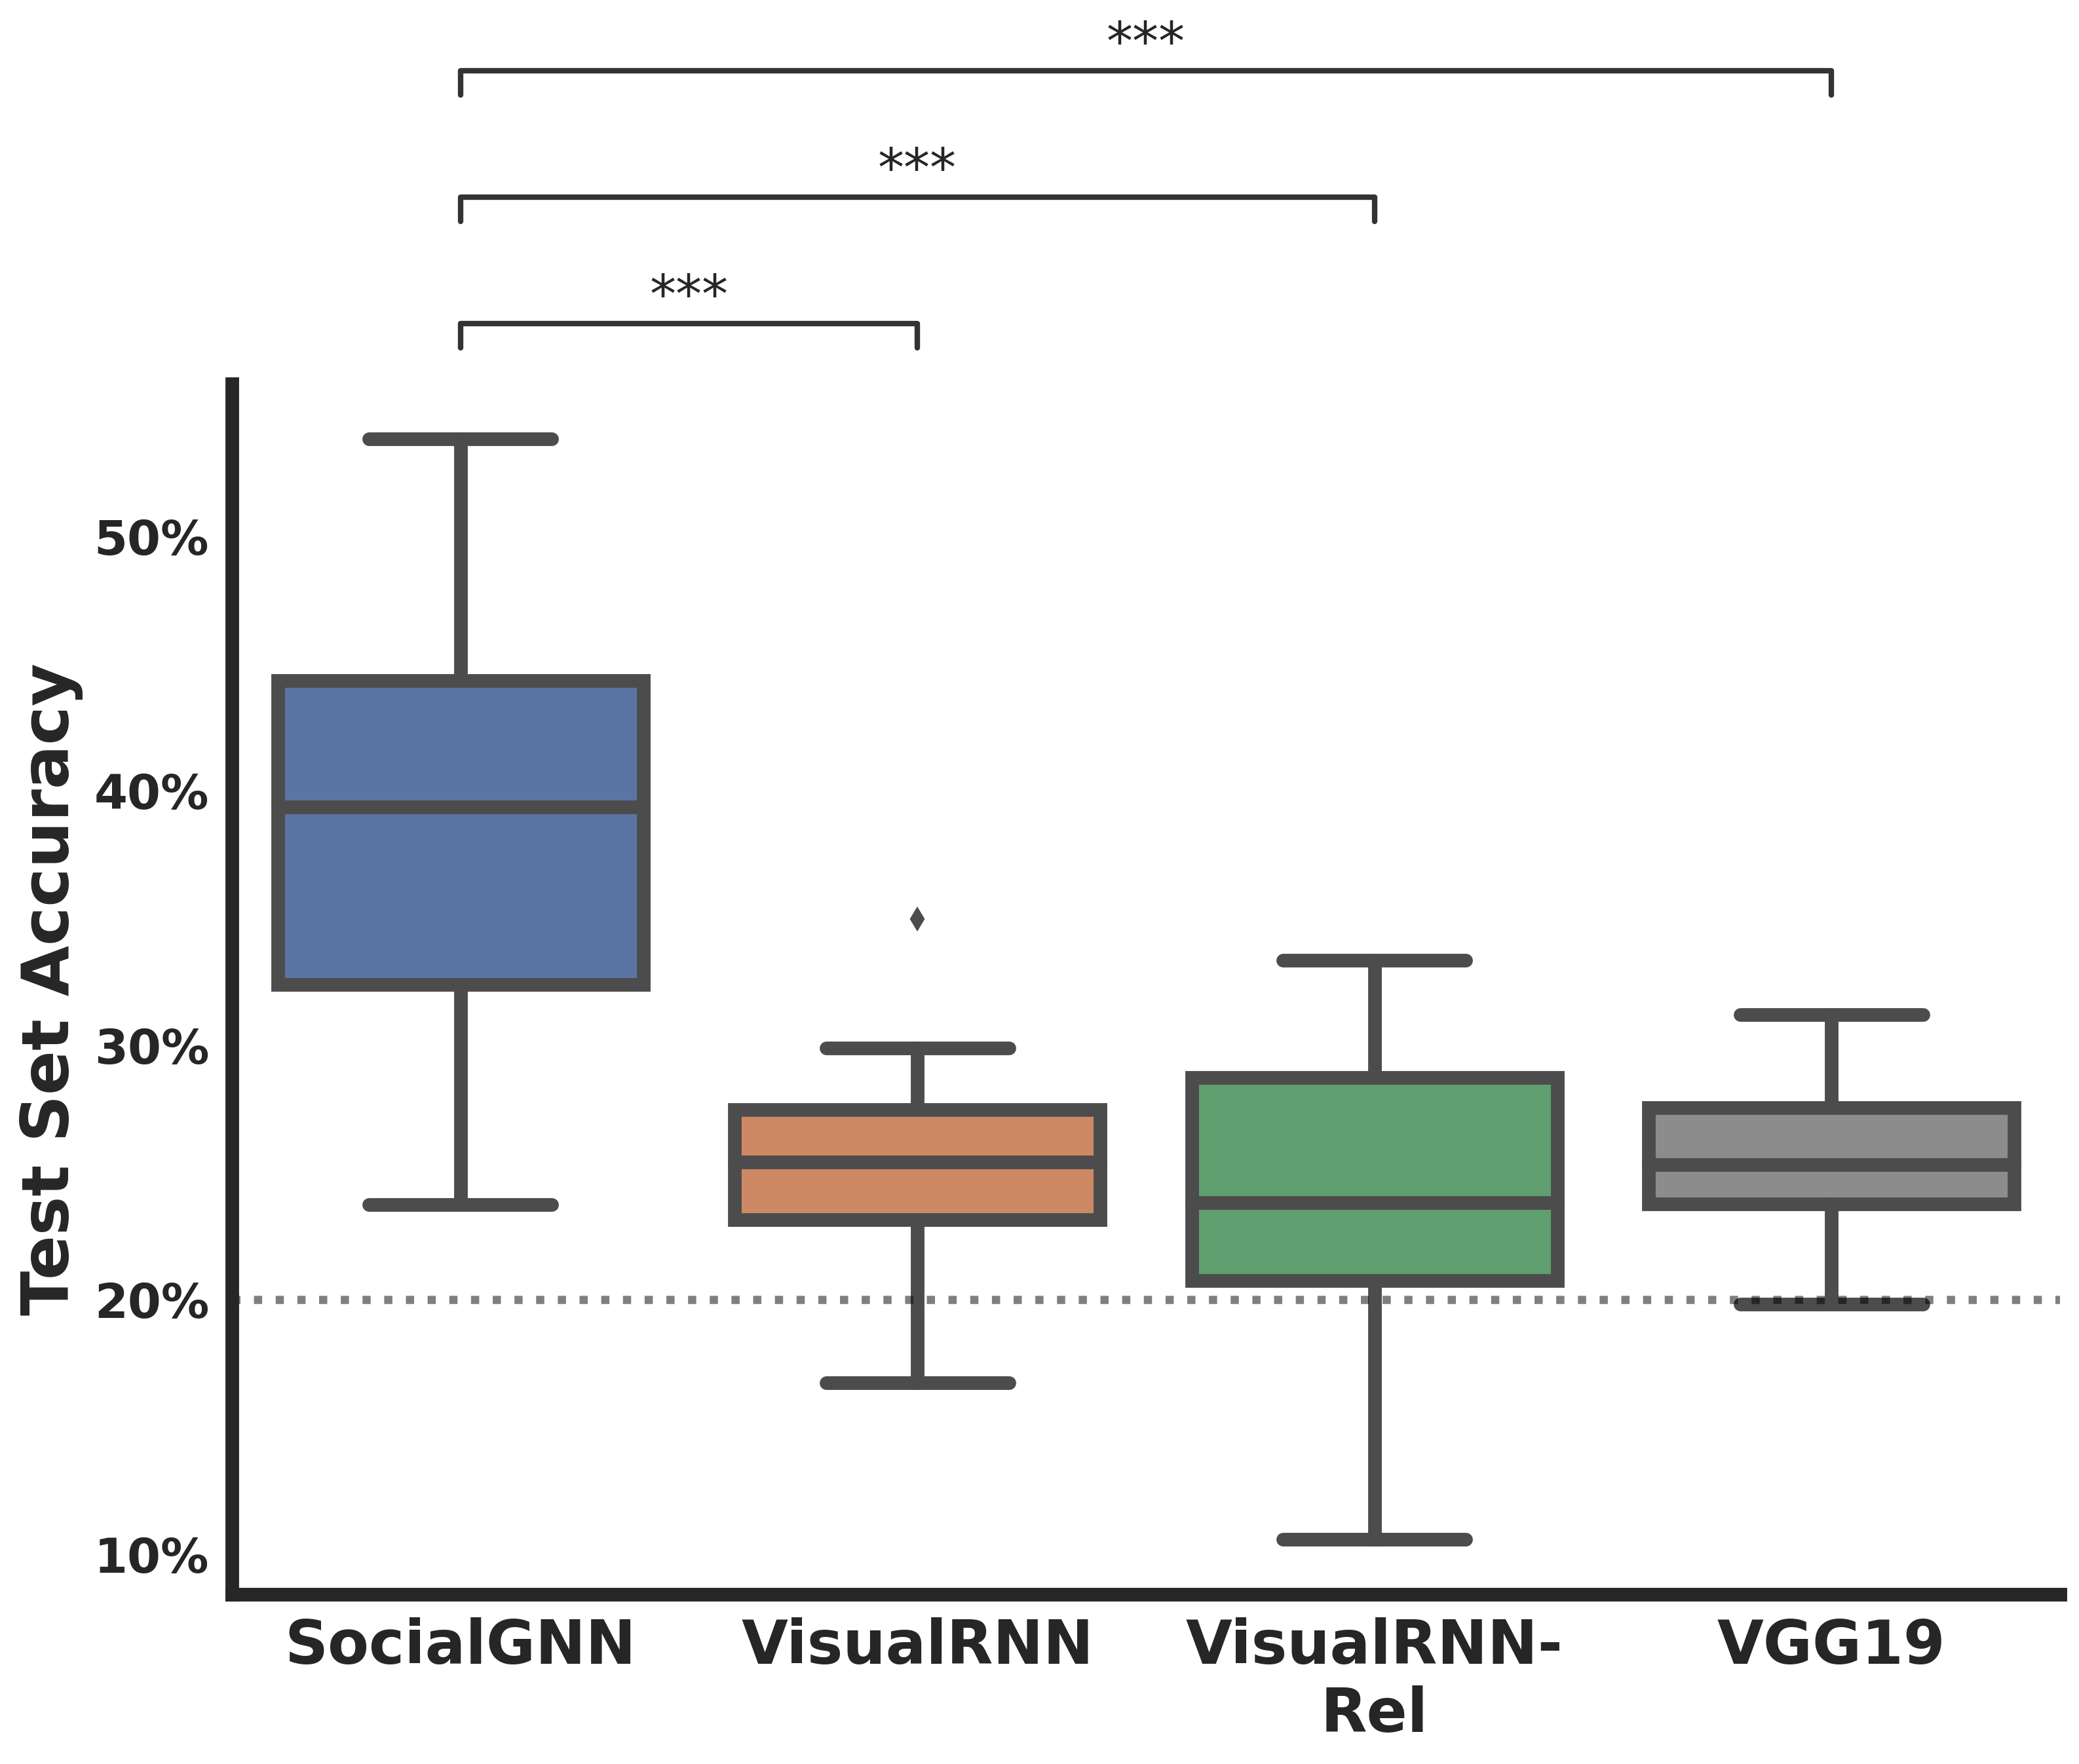

In [ ]:
#combined 5thJun and 14Jun all 4 models (visualRNN with 1e-3 lr used)
SocialGNN_V_5 = {'cross_val': [0.41768707482993195, 0.3983453237410072, 0.48165129065324763, 0.36624712815902505, 0.4097307510628248, 0.3028169014084507, 0.5180555555555556, 0.40378479824835783, 0.5136147609728823, 0.33661971830985915], 'entire_trainset': [0.45034013605442175, 0.3753581661891118, 0.495225102319236, 0.46534653465346537, 0.6153846153846154, 0.4943661971830986, 0.5861111111111111, 0.4834054834054834, 0.5355191256830601, 0.4394366197183099], 'testset': [0.4841628959276018, 0.34108527131782945, 0.5381165919282511, 0.42971887550200805, 0.4692982456140351, 0.4349593495934959, 0.4830508474576271, 0.3840304182509506, 0.42410714285714285, 0.46747967479674796]}
SocialGNN_V_14 = {'cross_val': [0.4347726269315674, 0.378705715635333, 0.40041863460712745, 0.3510791366906475, 0.46604734791729097, 0.40724637681159415, 0.42311302681992335, 0.3453448275862069, 0.4267375886524823, 0.3507042253521127], 'entire_trainset': [0.34880636604774534, 0.4573002754820937, 0.3888888888888889, 0.3366906474820144, 0.5098870056497176, 0.5376811594202898, 0.4066390041493776, 0.4544198895027624, 0.3229018492176387, 0.3380281690140845], 'testset': [0.25742574257425743, 0.40869565217391307, 0.2536764705882353, 0.32567049808429116, 0.4032258064516129, 0.38345864661654133, 0.31759656652360513, 0.375, 0.23715415019762845, 0.3048780487804878]}
SocialGNN_V = {'testset': SocialGNN_V_5['testset']+SocialGNN_V_14['testset']}
CueBasedLSTM_6_5 = {'cross_val': [0.2979591836734694, 0.31366906474820144, 0.30963563507594816, 0.2926980321646189, 0.29391591875295225, 0.276056338028169, 0.3138888888888889, 0.28712334480241897, 0.3019010343863573, 0.2267605633802817], 'entire_trainset': [0.40408163265306124, 0.3137535816618911, 0.40654843110504774, 0.3352192362093352, 0.36126373626373626, 0.35352112676056335, 0.3416666666666667, 0.3448773448773449, 0.36885245901639346, 0.3591549295774648], 'testset': [0.25339366515837103, 0.24806201550387597, 0.273542600896861, 0.28112449799196787, 0.2543859649122807, 0.2682926829268293, 0.2711864406779661, 0.16730038022813687, 0.2857142857142857, 0.34959349593495936]}
CueBasedLSTM_6_14 = {'cross_val': [0.27181456953642386, 0.2603495512517714, 0.26746457707170457, 0.25323741007194245, 0.3149335730696234, 0.2840579710144927, 0.260095785440613, 0.2736206896551724, 0.24886524822695036, 0.19014084507042256], 'entire_trainset': [0.22148541114058357, 0.2548209366391185, 0.40350877192982454, 0.34388489208633094, 0.3898305084745763, 0.39420289855072466, 0.30982019363762103, 0.425414364640884, 0.4182076813655761, 0.323943661971831], 'testset': [0.24257425742574257, 0.23043478260869565, 0.23161764705882354, 0.2988505747126437, 0.2782258064516129, 0.20300751879699247, 0.21888412017167383, 0.23275862068965517, 0.2608695652173913, 0.22764227642276422]}
CueBasedLSTM_6 = {'testset': CueBasedLSTM_6_5['testset']+CueBasedLSTM_6_14['testset']}
CueBasedLSTM_Relation_6_5 = {'cross_val': [0.26258503401360545, 0.2190647482014388, 0.27146584661261763, 0.21350514434122467, 0.27052432687765704, 0.23661971830985915, 0.25972222222222224, 0.28429777916796994, 0.25670487373031403, 0.2591549295774648], 'entire_trainset': [0.3741496598639456, 0.2020057306590258, 0.2646657571623465, 0.2814710042432815, 0.3282967032967033, 0.36338028169014086, 0.25416666666666665, 0.3362193362193362, 0.31830601092896177, 0.22816901408450704], 'testset': [0.2850678733031674, 0.18992248062015504, 0.273542600896861, 0.21285140562248997, 0.2236842105263158, 0.3333333333333333, 0.211864406779661, 0.20152091254752852, 0.28125, 0.18292682926829268]}
CueBasedLSTM_Relation_6_14 = {'cross_val': [0.21622075055187637, 0.23140292867265, 0.21921425504508374, 0.2719424460431655, 0.25714713814803714, 0.2942028985507246, 0.2558429118773946, 0.2734291187739464, 0.23627152988855116, 0.2605633802816902], 'entire_trainset': [0.28116710875331563, 0.3608815426997245, 0.25877192982456143, 0.4, 0.4209039548022599, 0.4072463768115942, 0.38865836791147995, 0.2265193370165746, 0.35704125177809387, 0.14788732394366197], 'testset': [0.2524752475247525, 0.2956521739130435, 0.21323529411764705, 0.26436781609195403, 0.3064516129032258, 0.2932330827067669, 0.3261802575107296, 0.1939655172413793, 0.20948616600790515, 0.10569105691056911]}
CueBasedLSTM_Relation_6 = {'testset': CueBasedLSTM_Relation_6_5['testset']+CueBasedLSTM_Relation_6_14['testset']}
VGG19mod_5 = {'cross_val': [0.20816326530612245, 0.21771839671120247, 0.2469294567141925, 0.23619019079013084, 0.2815777042985356, 0.2408450704225352, 0.22777777777777777, 0.2063809821707851, 0.25951915012580373, 0.27183098591549293], 'entire_trainset': [0.8448979591836735, 0.8424068767908309, 0.8635743519781719, 0.842998585572843, 0.8571428571428571, 0.8436619718309859, 0.8472222222222222, 0.8412698412698413, 0.8456284153005464, 0.8450704225352113], 'testset': [0.2850678733031674, 0.24806201550387597, 0.23766816143497757, 0.27309236947791166, 0.23684210526315788, 0.25609756097560976, 0.21610169491525424, 0.28517110266159695, 0.24553571428571427, 0.23577235772357724]}
VGG19mod_14 = {'cross_val': [0.20292273730684326, 0.2507227208313651, 0.2514813224559897, 0.24748201438848919, 0.25437019278793327, 0.2217391304347826, 0.24618773946360153, 0.28038314176245216, 0.24611955420466058, 0.2323943661971831], 'entire_trainset': [0.8408488063660478, 0.8691460055096418, 0.8538011695906432, 0.8431654676258993, 0.8573446327683616, 0.8521739130434782, 0.8533886583679114, 0.856353591160221, 0.8463726884779517, 0.8591549295774648], 'testset': [0.3118811881188119, 0.2826086956521739, 0.22794117647058823, 0.2720306513409962, 0.25, 0.2593984962406015, 0.2446351931330472, 0.19827586206896552, 0.2845849802371542, 0.25609756097560976]}
VGG19mod = {'testset': VGG19mod_5['testset']+VGG19mod_14['testset']}

from statannotations.stats.StatTest import StatTest
from statannotations.Annotator import Annotator
from scipy.stats import permutation_test
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def paired_mean_difference(data2, data1):
    return np.mean(np.array(data2) - np.array(data1))

df = pd.concat([pd.DataFrame(SocialGNN_V), pd.DataFrame(CueBasedLSTM_6), pd.DataFrame(CueBasedLSTM_Relation_6), pd.DataFrame(VGG19mod)], keys=['SocialGNN','VisualRNN', 'VisualRNN-Rel', 'VGG19']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")
plt.rcParams["figure.figsize"] = (12,8)

p = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)]
f = sns.boxplot(x="model",y="testset_accuracy", data=df, linewidth = 5, palette=p)
f.axhline(0.2, color = "black", ls = ":", alpha = 0.5, linewidth = 3) #alpha 0.8 for the poster

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=22)
f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=24)

# Significance testing
order = ['SocialGNN', 'VisualRNN', 'VisualRNN-Rel', 'VGG19']
pairs=[("SocialGNN", "VisualRNN"), ("SocialGNN", "VisualRNN-Rel"), ("SocialGNN", "VGG19")]
annotator = Annotator(f, pairs, data=df, x="model", y="testset_accuracy", order=order)
pvalues = []
for pair in pairs:
    data1 = df.groupby('model')['testset_accuracy'].get_group(pair[0])
    data2 = df.groupby('model')['testset_accuracy'].get_group(pair[1])
    res = permutation_test((data1, data2), statistic=paired_mean_difference, permutation_type='samples', n_resamples=10000)
    pvalues.append(res.pvalue)
(annotator
 .configure(comparisons_correction="HB", test=None, test_short_name='permuation_test', text_format='star', loc='outside', line_width = 2, line_offset=0.01, text_offset=0.01)
 .set_pvalues(pvalues=pvalues)
 .annotate())

sns.despine()
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

from google.colab import files
plt.savefig("gaze_5.png", bbox_inches = 'tight', transparent = False)
#files.download("gaze_5.png")

plt.show()